In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from math import radians, sin, cos, sqrt, atan2
import ast
from sklearn.metrics import r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt
from itertools import permutations
import seaborn as sns

In [2]:
# Load the datafiles
dirty_data_path = 'Group110_dirty_data.csv'
missing_data_path = 'Group110_missing_data.csv'
outlier_data_path = 'Group110_outlier_data.csv'

# Read and print the head of the dataframes
dirty_data_df = pd.read_csv(dirty_data_path)
print(dirty_data_df.head(10))
missing_data_df = pd.read_csv(missing_data_path)
print(missing_data_df.head(10))
outlier_data_df = pd.read_csv(outlier_data_path)
print(outlier_data_df.head(10))


    order_id   customer_id        date nearest_warehouse  \
0  ORD184160  ID6167344505  2019-28-08         Nickolson   
1  ORD446807  ID0588198716  2019-08-11         Nickolson   
2  ORD156155  ID0233255225  2019-11-10            Bakers   
3  ORD392895  ID0242532853  2019-04-30         Nickolson   
4  ORD370056  ID0440061349  2019-10-14            Bakers   
5  ORD222102  ID2325319146  2019-01-28          Thompson   
6  ORD166929  ID6237546435  2019-15-09            Bakers   
7  ORD030446  ID2841675041  2019-09-19         Nickolson   
8  ORD362380  ID2621587191  2019-10-14            Bakers   
9  ORD439361  ID0639368399  2019-09-13          Thompson   

                                       shopping_cart  order_price  \
0  [('Thunder line', 2), ('Universe Note', 2), ('...        25110   
1                  [('Alcon 10', 1), ('iStream', 1)]         9100   
2  [('iStream', 2), ('Thunder line', 2), ('Toshik...        21560   
3  [('iAssist Line', 1), ('Alcon 10', 2), ('Toshi...        331

### Missing Data imputation for each of the columns

In [3]:
# Check for missing values in each column
missing_values = missing_data_df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
order_id                          0
customer_id                       0
date                              0
nearest_warehouse                55
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse    31
latest_customer_review            0
is_happy_customer                40
dtype: int64


##### The code is designed to identify missing values within a dataset. It checks each column of the DataFrame (missing_data_df) and counts how many missing (null) values are present in each column. The result is a summary that shows how many missing values exist for each column, allowing the user to quickly assess data quality and understand where missing data might need to be handled or imputed. 

#### Filling missing values in 'nearest_warehouse' column

In [4]:
# Load warehouse coordinates from warehouses.csv file
warehouses_df = pd.read_csv('warehouses.csv')

# Haversine formula to calculate the distance between two points (lat1, lon1) and (lat2, lon2)
def haversine(lat1, lon1, lat2, lon2):
    R = 6378
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Function to find the nearest warehouse based on customer location
def find_nearest_warehouse(customer_lat, customer_long):
    min_distance = float('inf')
    nearest_warehouse = None
    for _, warehouse in warehouses_df.iterrows():
        distance = haversine(customer_lat, customer_long, warehouse['lat'], warehouse['lon'])
        if distance < min_distance:
            min_distance = distance
            nearest_warehouse = warehouse['names']
    return nearest_warehouse

# Impute missing values in 'nearest_warehouse' based on customer location
missing_data_df['nearest_warehouse'] = missing_data_df.apply(
    lambda row: find_nearest_warehouse(row['customer_lat'], row['customer_long']) if pd.isnull(row['nearest_warehouse']) else row['nearest_warehouse'],
    axis=1
)

# Output to verify imputation
print(missing_data_df[['order_id', 'nearest_warehouse', 'customer_lat', 'customer_long']].head(20))

     order_id nearest_warehouse  customer_lat  customer_long
0   ORD491231          Thompson    -37.807971     144.940646
1   ORD204737          Thompson    -37.806236     144.932455
2   ORD153979            Bakers    -37.811942     145.003982
3   ORD000610            Bakers    -37.810833     145.015999
4   ORD491457         Nickolson    -37.821443     144.957320
5   ORD221325          Thompson    -37.813473     144.952119
6   ORD280183          Thompson    -37.800868     144.953573
7   ORD409700          Thompson    -37.821092     144.947369
8   ORD442547         Nickolson    -37.810231     144.961403
9   ORD327162          Thompson    -37.802903     144.945419
10  ORD286395         Nickolson    -37.814120     144.968115
11  ORD199133          Thompson    -37.811993     144.938405
12  ORD053923         Nickolson    -37.824069     144.964353
13  ORD338117         Nickolson    -37.820120     144.966982
14  ORD149333          Thompson    -37.820726     144.941532
15  ORD270931          T

##### This code aims to fill in missing values for the nearest_warehouse column in a dataset by calculating the nearest warehouse based on the customer's geographic location (latitude and longitude). Here's the overall logic:

1. Warehouse Data Loading: It first loads warehouse coordinates (latitude and longitude) from a file (warehouses.csv) to have the necessary reference points for each warehouse.

2. Distance Calculation: It uses the Haversine formula, which calculates the great-circle distance between two points on the Earth's surface, to compute the distance between a customer's location and each warehouse's location.

3. Finding Nearest Warehouse: For each row in the dataset with missing nearest_warehouse values, the code calculates the distances to all the warehouses. It identifies the closest warehouse based on the smallest Haversine distance.

4. Imputation of Missing Values: The missing nearest_warehouse values are then filled in with the nearest warehouse determined from the above calculations.

5. Verification: Finally, it prints out a sample of the dataset with the filled nearest_warehouse values, allowing for a quick verification of the imputation process.

#### Calculating 'item_unit_price' for each product and then imputing the 'order_price' column

In [5]:
# Function extract items and quantities from 'shopping_cart'
def extract_items_quantities(cart_str):
    try:
        return ast.literal_eval(cart_str)
    except:
        return []

# Create a new column with parsed shopping cart data
missing_data_df['parsed_cart'] = missing_data_df['shopping_cart'].apply(extract_items_quantities)

# Set up the system of equations for unit prices using non-missing order_price rows
known_prices_df = missing_data_df[missing_data_df['order_price'].notna()]

# Build matrices for the system of equations
# Create a list of unique items
all_items = set(item for cart in known_prices_df['parsed_cart'] for item, _ in cart)
all_items = sorted(list(all_items))  # Sort items to have a consistent order
num_items = len(all_items)

# Build the matrix of quantities and the corresponding order prices
quantities_matrix = []
order_prices = []

for _, row in known_prices_df.iterrows():
    quantities = [0] * num_items
    for item, qty in row['parsed_cart']:
        item_index = all_items.index(item)
        quantities[item_index] = qty
    quantities_matrix.append(quantities)
    order_prices.append(row['order_price'])

# Convert to numpy arrays
quantities_matrix = np.array(quantities_matrix)
order_prices = np.array(order_prices)

# Solve for the unit prices using numpy.linalg.lstsq (least squares method)
unit_prices, residuals, rank, s = np.linalg.lstsq(quantities_matrix, order_prices, rcond=None)

# Create a dictionary for item unit prices
item_unit_prices = {item: price for item, price in zip(all_items, unit_prices)}

# Print the calculated unit prices for each item
print("Calculated Item Unit Prices:")
for item, price in item_unit_prices.items():
    print(f"{item}: {price:.2f}")

# Function to calculate the correct order price based on items in the shopping cart and their unit prices
def calculate_order_price(cart, item_unit_prices):
    total_price = 0
    for item, qty in cart:
        if item in item_unit_prices:
            total_price += item_unit_prices[item] * qty
    return round(total_price, 2)

# Impute missing order_price values
missing_data_df['order_price'] = missing_data_df.apply(
    lambda row: round(calculate_order_price(row['parsed_cart'], item_unit_prices), 1) if pd.isnull(row['order_price']) else row['order_price'],
    axis=1
)

# Clean up by removing the parsed_cart column
missing_data_df.drop(columns=['parsed_cart'], inplace=True)

# Output to verify imputation
print(missing_data_df[['order_id', 'order_price', 'shopping_cart']].head(30))


Calculated Item Unit Prices:
Alcon 10: 8950.00
Candle Inferno: 430.00
Lucent 330S: 1230.00
Olivia x460: 1225.00
Thunder line: 2180.00
Toshika 750: 4320.00
Universe Note: 3450.00
iAssist Line: 2225.00
iStream: 150.00
pearTV: 6310.00
     order_id  order_price                                      shopping_cart
0   ORD491231      11270.0  [('iAssist Line', 2), ('Thunder line', 2), ('L...
1   ORD204737      41780.0  [('Universe Note', 2), ('pearTV', 2), ('Thunde...
2   ORD153979       6585.0         [('iAssist Line', 1), ('Thunder line', 2)]
3   ORD000610      21220.0  [('Alcon 10', 2), ('Candle Inferno', 2), ('Luc...
4   ORD491457       1375.0               [('iStream', 1), ('Olivia x460', 1)]
5   ORD221325      30640.0  [('Toshika 750', 2), ('Candle Inferno', 1), ('...
6   ORD280183       3755.0  [('Lucent 330S', 1), ('iAssist Line', 1), ('iS...
7   ORD409700      33605.0  [('pearTV', 2), ('iAssist Line', 1), ('Alcon 1...
8   ORD442547      13320.0  [('Lucent 330S', 1), ('Universe Note',

##### This code addresses missing values in the order_price column of a dataset by calculating the prices based on the contents of the shopping_cart column. The goal is to fill in missing order_price values using the unit prices of the items listed in each shopping cart. Here’s the overall logic:

1. Extracting Item and Quantity Information from the Shopping Cart:
The code begins by extracting the contents of the shopping_cart column, which contains a list of items and their quantities in string format. Using a function (extract_items_quantities), the string data is parsed into a list of tuples, where each tuple contains the item name and its quantity. This parsed information is stored in a new column (parsed_cart), providing a structured way to access the shopping cart contents.

2. Setting up the System of Equations for Unit Prices:
To impute missing order_price values, the code uses rows where the order_price is available to calculate unit prices for each item in the shopping cart. It creates a system of linear equations by: 
    Listing Unique Items: The code collects all the unique items from the shopping carts, ensuring they are sorted in a consistent order.
    Building Quantities Matrix: For each row, the quantities of items in the shopping cart are captured, forming a matrix of item quantities for all orders.
    Order Prices: The order_price values for each order form the target values in the system of equations.

3. Calculating Unit Prices Using Least Squares:
Using the numpy lstsq (least squares) method, the code solves for the unit prices of each item. This method attempts to find the best-fit solution for unit prices by minimizing the sum of squared residuals (the difference between actual and predicted values). The unit prices for all items are stored in a dictionary (item_unit_prices), mapping each item to its calculated price.

4. Imputing Missing Order Prices:
With the unit prices available, the code calculates the total price for each shopping cart by multiplying the quantity of each item by its unit price. For rows with missing order_price values, this computed total is used to fill in the missing value. If an item in the shopping cart doesn’t have a corresponding unit price, the total price is set to NaN for that row.

5. Cleaning Up:
Once the missing order_price values are imputed, the temporary parsed_cart column (which stores the parsed shopping cart data) is dropped to clean up the dataframe.

#### Filling missing values in 'distance_to_nearest_warehouse' column

In [6]:
# Function to calculate the nearest warehouse distance
def find_nearest_warehouse(customer_lat, customer_long):
    distances = []
    for _, warehouse in warehouses_df.iterrows():
        distance = haversine(customer_lat, customer_long, warehouse['lat'], warehouse['lon'])
        distances.append(distance)
    return min(distances)  # Return the minimum distance (nearest warehouse)

# Fill missing 'distance_to_nearest_warehouse' by calculating distances to nearest warehouse
missing_data_df['distance_to_nearest_warehouse'] = missing_data_df.apply(
    lambda row: find_nearest_warehouse(row['customer_lat'], row['customer_long']) if pd.isnull(row['distance_to_nearest_warehouse']) else row['distance_to_nearest_warehouse'],
    axis=1
)

# Output to verify imputation
print(missing_data_df[['order_id', 'customer_lat', 'customer_long', 'distance_to_nearest_warehouse']].head(30))

     order_id  customer_lat  customer_long  distance_to_nearest_warehouse
0   ORD491231    -37.807971     144.940646                       0.770100
1   ORD204737    -37.806236     144.932455                       1.471500
2   ORD153979    -37.811942     145.003982                       0.799400
3   ORD000610    -37.810833     145.015999                       1.828700
4   ORD491457    -37.821443     144.957320                       1.121300
5   ORD221325    -37.813473     144.952119                       0.453000
6   ORD280183    -37.800868     144.953573                       1.433200
7   ORD409700    -37.821092     144.947369                       0.937500
8   ORD442547    -37.810231     144.961403                       1.174900
9   ORD327162    -37.802903     144.945419                       1.097200
10  ORD286395    -37.814120     144.968115                       0.513900
11  ORD199133    -37.811993     144.938405                       0.765700
12  ORD053923    -37.824069     144.96

##### The main goal of this code is to fill in the missing values for the distance between the customer and the nearest warehouse in the dataset. Since warehouses are located at known geographic coordinates, the code uses the customer’s latitude and longitude to calculate the distance to each warehouse and selects the shortest distance (i.e., the nearest warehouse). The result is used to populate the missing values in the distance_to_nearest_warehouse column.

1. Haversine Formula for Distance Calculation: The code uses the Haversine formula to calculate the great-circle distance between two points on the Earth's surface, given their latitude and longitude in degrees. The formula accounts for the Earth's curvature, making it appropriate for calculating distances between geographic coordinates.

2. The function haversine(lat1, lon1, lat2, lon2) takes in the latitude and longitude of two points (in this case, the customer’s location and the warehouse location) and returns the distance between them in kilometers.
The Earth's radius is set as 6378 km in the formula, and trigonometric functions are used to compute the distance based on the angular differences between the two locations.

3. Finding the Nearest Warehouse: The function find_nearest_warehouse(customer_lat, customer_long) calculates the distance between the customer’s location and each warehouse.
It iterates through all the warehouse locations (stored in warehouses_df) and uses the haversine function to compute the distance between the customer’s coordinates and each warehouse.
After calculating all the distances, it returns the minimum distance, representing the distance to the nearest warehouse.

4. Imputing Missing Distances: The next step is to impute the missing values in the distance_to_nearest_warehouse column. For rows where this value is missing (checked using pd.isnull()), the code calculates the distance to the nearest warehouse using the find_nearest_warehouse function and fills in the missing value.
The .apply() method is used on the missing_data_df DataFrame, applying the logic row by row. If the distance_to_nearest_warehouse value is missing, the function computes the correct distance; otherwise, the original value is retained.

5. Output Verification: After the missing values are filled in, the code prints a sample of the data (first 30 rows) to verify that the distance_to_nearest_warehouse column has been correctly imputed.

#### Imputing missing values in 'is_happy_customer' column

In [7]:
# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify customer happiness based on review sentiment
def classify_happiness(review):
    if pd.isnull(review):
        return 0
    sentiment = sia.polarity_scores(review)
    return 1 if sentiment['compound'] >= 0.05 else 0

# Fill missing 'is_happy_customer' using sentiment analysis on 'latest_customer_review'
missing_data_df['is_happy_customer'] = missing_data_df.apply(
    lambda row: classify_happiness(row['latest_customer_review']) if pd.isnull(row['is_happy_customer']) else row['is_happy_customer'],
    axis=1
)

# Output to verify imputation
print(missing_data_df[['order_id', 'latest_customer_review', 'is_happy_customer']].head(30))

     order_id                             latest_customer_review  \
0   ORD491231  excellent. though i wish i had done more resea...   
1   ORD204737                 broken i order one but came broken   
2   ORD153979  warning: this is an unlocked t mobile device w...   
3   ORD000610  i love this tablet. it's easy to use, a great ...   
4   ORD491457  great deal for a great price! as advertised at...   
5   ORD221325                          great phone! great phone!   
6   ORD280183  toshika es lo mejor excelente teléfono único y...   
7   ORD409700                                         great good   
8   ORD442547  xx bought in rural alaska. took a while to get...   
9   ORD327162  very good for a budget phone the device is a s...   
10  ORD286395  set up easy. swapped the 2 amp charger it came...   
11  ORD199133  four stars love this phone. built like a tank....   
12  ORD053923  great product triple the minutes item arrived ...   
13  ORD338117  i requested a silver one for my w

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ashwingururaj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### The code is designed to fill in missing values in the is_happy_customer column based on the sentiment analysis of customer reviews. It utilizes VADER (Valence Aware Dictionary and sEntiment Reasoner), a tool that is specifically tuned for sentiment analysis of social media text, and classifies customer happiness based on the polarity of their reviews. The main goal of this code is to predict and fill missing values in the is_happy_customer column, which presumably indicates whether the customer is satisfied with their purchase or service, using sentiment analysis. The sentiment of the customer's review (stored in the latest_customer_review column) is analyzed, and if the review sentiment is positive, the customer is classified as happy (value of 1), otherwise as unhappy (value of 0).


1. VADER Lexicon Download and Initialization: The code starts by downloading the VADER sentiment analysis lexicon, which contains a pre-built dictionary for sentiment analysis.
It then initializes the SentimentIntensityAnalyzer from the nltk library to perform the sentiment analysis. This analyzer computes sentiment polarity for the input text and classifies it as positive, neutral, or negative.

2. Sentiment Classification of Customer Reviews: The function classify_happiness(review) is created to analyze the sentiment of a review.
For each customer review, the function checks if the review is missing (pd.isnull(review)), and if so, it returns a default value of 0 (indicating that the customer is not happy since no review is available).
If a review is present, the polarity_scores() method of the sentiment analyzer is applied to the review. This method returns a dictionary of sentiment scores (negative, neutral, positive, and compound), where the compound score gives an overall measure of sentiment.
The compound score ranges from -1 (most negative) to +1 (most positive). If the compound score is greater than or equal to 0.05 (a common threshold for positive sentiment), the function classifies the customer as happy by returning 1; otherwise, it returns 0 (unhappy).

3. Imputation of Missing is_happy_customer Values: The missing values in the is_happy_customer column are filled based on the sentiment of the customer's review. The .apply() function is used to apply this logic row by row in the DataFrame.
For each row, the function checks if the is_happy_customer value is missing. If it is, the code uses the classify_happiness function to predict customer happiness from the sentiment of the latest_customer_review. If the value is not missing, the original value is retained.
This ensures that missing values are filled only for rows where is_happy_customer is null, and the rest of the data remains intact.

4. Output for Verification: The code prints the first 30 rows of the DataFrame to verify that the missing values in is_happy_customer have been correctly imputed based on the review sentiment. The output includes the order_id, latest_customer_review, and is_happy_customer columns.

#### Imputing missing values in 'delivery_charges' column by training a Linear Regression model

In [8]:
# Define the features and target for linear regression
features = ['distance_to_nearest_warehouse', 'is_expedited_delivery_temp', 'is_happy_customer_temp']
target = 'delivery_charges'

# Create temporary columns to convert categorical features to numeric for training purposes
missing_data_df['is_expedited_delivery_temp'] = missing_data_df['is_expedited_delivery'].astype(int)
missing_data_df['is_happy_customer_temp'] = missing_data_df['is_happy_customer'].astype(int)

# Create a copy of the original dataset to track the filled missing values
filled_missing_df = missing_data_df[missing_data_df[target].isna()].copy()

# Split the dataset by season
seasons = missing_data_df['season'].unique()
delivery_charge_models_by_season = {}

# Loop through each season and train a separate model
for season in seasons:
    # Filter dataset for the current season
    season_df = missing_data_df[missing_data_df['season'] == season]
    
    # Separate rows with missing and non-missing delivery charges
    train_df = season_df[season_df[target].notna()]
    test_df = season_df[season_df[target].isna()]
    
    if not train_df.empty:
        # Train linear regression model on non-missing rows
        X_train = train_df[features]
        y_train = train_df[target]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Store the model for the current season
        delivery_charge_models_by_season[season] = model
        
        # If there are missing delivery charges, predict them using the model
        if not test_df.empty:
            X_test = test_df[features]
            predicted_charges = model.predict(X_test)
            predicted_charges = [round(charge, 2) for charge in predicted_charges]
            missing_data_df.loc[test_df.index, 'delivery_charges'] = predicted_charges
            filled_missing_df.loc[test_df.index, 'delivery_charges'] = predicted_charges
        
        # Calculate and print R² score for the current season
        y_pred = model.predict(X_train)
        r2 = r2_score(y_train, y_pred)
        print(f"R² Score for {season}: {r2}")

# Drop the temporary columns used for training
missing_data_df.drop(columns=['is_expedited_delivery_temp', 'is_happy_customer_temp'], inplace=True)

# Output the filled missing values
print("\nMissing delivery charges that have been filled:")
print(filled_missing_df[['order_id', 'season', 'delivery_charges']])


R² Score for Winter: 0.990533883692262
R² Score for Spring: 0.9948772411842595
R² Score for Autumn: 0.9915722916656253
R² Score for Summer: 0.9941973238700212

Missing delivery charges that have been filled:
      order_id  season  delivery_charges
25   ORD042303  Spring             83.66
54   ORD113206  Winter             83.13
56   ORD101202  Summer             73.91
58   ORD281511  Spring            114.04
107  ORD492095  Summer             81.08
108  ORD289501  Winter             67.56
140  ORD092336  Summer             74.27
153  ORD326223  Winter             49.67
164  ORD088211  Winter             81.94
165  ORD045668  Spring             86.76
167  ORD491242  Summer             89.14
178  ORD363980  Autumn             66.24
180  ORD167016  Summer             63.03
182  ORD398166  Autumn             55.61
185  ORD279242  Summer             72.44
195  ORD491527  Autumn             80.52
207  ORD443612  Spring            118.29
226  ORD112501  Summer             66.35
231  ORD03816

##### The aim is to predict and fill in the missing values for delivery_charges using a machine learning approach, specifically linear regression. The model leverages several features like distance_to_nearest_warehouse, whether the delivery is expedited (is_expedited_delivery), and customer happiness (is_happy_customer) to predict delivery charges. Since delivery charges may vary seasonally, a separate regression model is trained for each season.

1. Feature Preparation: The code first identifies the features (distance_to_nearest_warehouse, is_expedited_delivery, and is_happy_customer) that will be used for predicting delivery_charges.
To make these categorical features compatible with the linear regression model, is_expedited_delivery and is_happy_customer are temporarily converted into numeric values (1 for True, 0 for False). These temporary columns (is_expedited_delivery_temp and is_happy_customer_temp) are used during model training and prediction.
These temp columns are used only for the prediction process and will not alter the original dataset. Once predictions are made, the data is reverted to its original form where these fields are represented as True or False.

2. Splitting Data by Season: Since delivery charges may differ across seasons, the data is split based on the season column. A separate linear regression model is trained for each season (e.g., Winter, Spring, Summer, Autumn).
This ensures that the model captures any seasonal trends that might influence delivery charges, such as increased demand during certain times of the year or different shipping policies.

3. Training the Model for Each Season: For each season, the rows that have valid (non-missing) delivery_charges are used to train the linear regression model. The input features are distance_to_nearest_warehouse, is_expedited_delivery_temp, and is_happy_customer_temp, and the target variable is delivery_charges.
After training the model for each season, the trained model is stored in the delivery_charge_models_by_season dictionary for future predictions on that specific season.

4. Predicting Missing Values: For rows within each season that have missing delivery_charges, the corresponding model predicts the missing values using the trained regression model.
These predicted values are then inserted into the missing_data_df DataFrame, where delivery charges were missing.
The missing values that are filled are also stored in a separate DataFrame (filled_missing_df) for further analysis or reporting.

5. Model Evaluation: After training the linear regression model for each season, the code calculates and prints the R² score.
The R² score indicates how well the model fits the data, with a higher score suggesting a better fit. This helps evaluate how accurately the model predicts delivery charges for each season, ensuring that the model captures any significant patterns in the data.

6. Output: The missing values for delivery_charges that have been imputed by the model are printed for verification. The code provides a summary of the filled values, showing the order_id, the season, and the predicted delivery_charges.
The original columns (is_expedited_delivery and is_happy_customer) are reverted to their original True/False format after prediction, ensuring that the data remains consistent for further analysis.

7. Temporary Columns Usage: During model training and prediction, is_expedited_delivery and is_happy_customer are temporarily converted into integers (is_expedited_delivery_temp and is_happy_customer_temp). This conversion is necessary because machine learning models like linear regression require numeric inputs to make predictions.
However, these temporary columns are only used during the modeling process. Once the predictions have been made and the missing values filled, these columns are discarded, and the original columns (is_expedited_delivery and is_happy_customer) are restored to their True/False state, ensuring no permanent modification to the original dataset.

#### Imputing missing values in 'order_total' column

In [9]:
# Function to calculate the order total based on the given logic
def calculate_order_total(row):
    if pd.isnull(row['order_total']):
        # Apply the coupon discount to the order_price, then add delivery charges
        discounted_price = row['order_price'] * (1 - row['coupon_discount'] / 100)
        total_price = discounted_price + row['delivery_charges']
        return round(total_price, 2)  # Rounded to 2 decimal places for financial values
    return row['order_total']  # If order_total is not missing, return the existing value

# Apply the function to impute missing order_total values
missing_data_df['order_total'] = missing_data_df.apply(calculate_order_total, axis=1)

# Output the rows where missing order_total values have been filled
filled_order_total_df = missing_data_df[missing_data_df['order_total'].isna() == False].copy()
print("\nMissing order_total values that have been filled:")
print(filled_order_total_df[['order_id', 'order_price', 'coupon_discount', 'delivery_charges', 'order_total']].head(30))



Missing order_total values that have been filled:
     order_id  order_price  coupon_discount  delivery_charges  order_total
0   ORD491231      11270.0                5             65.19     10771.69
1   ORD204737      41780.0                0             90.67     41870.67
2   ORD153979       6585.0               25             50.73      4989.48
3   ORD000610      21220.0                5             85.97     20244.97
4   ORD491457       1375.0                0             79.46      1454.46
5   ORD221325      30640.0               10             98.71     27674.71
6   ORD280183       3755.0               10             78.87      3458.37
7   ORD409700      33605.0               15             66.80     28631.05
8   ORD442547      13320.0                5             67.57     12721.57
9   ORD327162       4685.0               10             67.43      4283.93
10  ORD286395      12380.0                5             63.25     11824.25
11  ORD199133       2890.0               25      

##### This code imputes missing values in the order_total column by calculating the total based on the available order_price, coupon_discount, and delivery_charges. The logic used ensures that any missing values for order_total are filled using a defined formula, while rows with existing values are left unchanged.

1. Imputation of Missing order_total: The main task is to compute the order_total for rows where this value is missing. The formula for calculating order_total is:
Apply the coupon_discount to the order_price, reducing it by the percentage discount.
Add the delivery_charges to the discounted price to get the final order_total.

2. Conditional Imputation: For rows where order_total is missing (pd.isnull(row['order_total'])), the calculation is performed using the formula. The result is rounded to two decimal places for accuracy in financial calculations.
If the order_total is not missing, the existing value is retained, and no changes are made.

3. Filling the Missing Values: The computed order_total values are filled into the missing slots in the order_total column of the dataset.
The code then outputs a portion of the dataset where the previously missing order_total values have been successfully imputed, displaying related fields (order_id, order_price, coupon_discount, delivery_charges, and order_total) for verification.

#### Saving the imputed missing data to 'Group110_missing_data_solution.csv'

In [10]:
# Save the updated dataset with all imputed values
missing_data_df.to_csv('Group110_missing_data_solution.csv', index=False)

# Output to verify imputation and that the solution file is written correctly
print("Missing data imputation completed and saved to Group110_missing_data_solution.csv.", missing_data_df.head())

Missing data imputation completed and saved to Group110_missing_data_solution.csv.     order_id   customer_id        date nearest_warehouse  \
0  ORD491231  ID0641022879  2019-06-24          Thompson   
1  ORD204737  ID3106293103  2019-09-01          Thompson   
2  ORD153979  ID0030947984  2019-04-22            Bakers   
3  ORD000610  ID5668009834  2019-10-29            Bakers   
4  ORD491457  ID3157171395  2019-10-05         Nickolson   

                                       shopping_cart  order_price  \
0  [('iAssist Line', 2), ('Thunder line', 2), ('L...      11270.0   
1  [('Universe Note', 2), ('pearTV', 2), ('Thunde...      41780.0   
2         [('iAssist Line', 1), ('Thunder line', 2)]       6585.0   
3  [('Alcon 10', 2), ('Candle Inferno', 2), ('Luc...      21220.0   
4               [('iStream', 1), ('Olivia x460', 1)]       1375.0   

   delivery_charges  customer_lat  customer_long  coupon_discount  \
0             65.19    -37.807971     144.940646                5   
1  

### Dirty Data Cleaning 

#### Inconsistent date formats checks

In [11]:
# Identifying invalid date entries by attempting to convert to datetime
invalid_date_mask = pd.to_datetime(dirty_data_df['date'], errors='coerce').isna()

# Displaying order_id and date for rows with invalid date format
if invalid_date_mask.any():
    print("Invalid date entries found:\n", dirty_data_df.loc[invalid_date_mask, ['order_id', 'date']])

# Counting the number of invalid date format entries
invalid_date_count = invalid_date_mask.sum()
print(f"\nTotal invalid date format errors: {invalid_date_count}")

# Function to fix the dates
def adjust_date_format(date_str):
    try:
        components = date_str.split('-')
        if len(components) == 3:
            year = int(components[0]) if len(components[0]) == 4 else int(components[2])
            day = int(components[2]) if len(components[0]) == 4 else int(components[0])
            month = int(components[1])
            if month > 12:
                day, month = month, day
            return f"{year:04d}-{month:02d}-{day:02d}"
        return date_str
    except Exception as ex:
        return pd.NaT

# Applying the function to fix and correct dates
dirty_data_df['adjusted_date'] = dirty_data_df['date'].apply(adjust_date_format)

# Creating a flag column to indicate rows with corrected dates
dirty_data_df['date_correction_flag'] = dirty_data_df['date'] != dirty_data_df['adjusted_date']

# Displaying the entries where the date was corrected
corrected_rows = dirty_data_df[dirty_data_df['date'] != dirty_data_df['adjusted_date']]
if not corrected_rows.empty:
    print("Corrected date entries:\n", corrected_rows[['order_id', 'date', 'adjusted_date']])

# Converting the 'adjusted_date' column to datetime format
dirty_data_df['date_column'] = pd.to_datetime(dirty_data_df['adjusted_date'], errors='coerce')

# Checking for any remaining invalid dates after correction
remaining_invalid_dates = dirty_data_df['date'].isna()
if remaining_invalid_dates.any():
    print("Remaining invalid date entries after correction:\n", dirty_data_df[remaining_invalid_dates])
else:
    print("All date entries are valid and follow the 'YYYY-MM-DD' format after correction.")
    
# Applying the adjusted_date values to the actual date column
dirty_data_df['date'] = dirty_data_df['adjusted_date']

dirty_data_df.drop(columns=['adjusted_date', 'date_correction_flag', 'date_column'], inplace=True)

# Displaying the updated data with corrected dates
print("\nUpdated Data with Corrected Dates in the 'date' column:")
print(dirty_data_df[['order_id', 'date']].head())

Invalid date entries found:
       order_id        date
0    ORD184160  2019-28-08
6    ORD166929  2019-15-09
21   ORD096339  2019-22-03
47   ORD181049  2019-29-12
116  ORD439096  2019-15-01
139  ORD067483  2019-15-10
205  ORD058709  2019-27-03
224  ORD045401  2019-29-11
292  ORD161311  2019-18-08
323  ORD124280  2019-14-09
398  ORD277168  2019-21-04
488  ORD292782  2019-27-07

Total invalid date format errors: 12
Corrected date entries:
       order_id        date adjusted_date
0    ORD184160  2019-28-08    2019-08-28
6    ORD166929  2019-15-09    2019-09-15
20   ORD468134  10-09-2019    2019-09-10
21   ORD096339  2019-22-03    2019-03-22
47   ORD181049  2019-29-12    2019-12-29
51   ORD194786  03-10-2019    2019-10-03
54   ORD020677  02-06-2019    2019-06-02
78   ORD028734  11-07-2019    2019-07-11
91   ORD481202  04-05-2019    2019-05-04
92   ORD494431  05-12-2019    2019-12-05
108  ORD365125  06-03-2019    2019-03-06
116  ORD439096  2019-15-01    2019-01-15
139  ORD067483  2019-15-

/var/folders/xr/xyn5tvdx2s52y5y4xgywsyfc0000gn/T/ipykernel_87533/310467191.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  invalid_date_mask = pd.to_datetime(dirty_data_df['date'], errors='coerce').isna()


##### This code identifies invalid date formats in a dataset, attempts to correct them, and replaces the invalid dates with corrected ones. It works as follows:

1. Identifying Invalid Date Entries: The code uses pd.to_datetime() to attempt conversion of the date column into a valid datetime format. Rows that fail to convert (invalid date formats) are flagged using errors='coerce', which turns invalid dates into NaT.
The invalid_date_mask is created to track which rows have invalid date formats (NaT values).

2. Displaying and Counting Invalid Dates: If there are any invalid dates, the order_id and date columns of those rows are printed. The total number of invalid date entries is counted and printed.

3. Defining a Function to Adjust Dates: The adjust_date_format function attempts to correct invalid date formats. It splits the date string by the - separator, checks for year, month, and day placements, and reorders them to the correct format (YYYY-MM-DD).
If the month value exceeds 12 (likely swapped with day), it swaps day and month values.

4. Applying the Date Fix: The adjust_date_format function is applied to the date column, creating a new adjusted_date column that stores the corrected dates.

5. Flagging Corrected Dates: A new column date_correction_flag is created to flag rows where the original date and adjusted_date differ, indicating that a correction was made.

6. Displaying Corrected Entries: Rows where the date was corrected are printed to show which dates were adjusted.

7. Converting Adjusted Dates to Datetime Format: The adjusted_date column is converted to a valid datetime format using pd.to_datetime() and stored in a new column date_column.

8. Checking for Remaining Invalid Dates: After the correction, the code checks if any dates are still invalid (NaT values) and prints those remaining invalid entries. If all dates are now valid, a message is printed indicating that all dates follow the YYYY-MM-DD format.

#### Season Value Checks

In [12]:
# B. Checking for invalid or inconsistent season values (capitalization and invalid values)
# Defining valid season values
valid_seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

# Identify rows with invalid seasons values after standardizing
invalid_seasons_mask = ~dirty_data_df['season'].isin(valid_seasons)

print(f"\nTotal invalid season value errors: ", invalid_seasons_mask.sum())

# Standardize the season column by converting it to title case for valid values
dirty_data_df['season'] = dirty_data_df['season'].str.title()


Total invalid season value errors:  22


##### The logic in this code is focused on identifying and correcting inconsistencies in season values by standardizing them to a set of valid options. Here's a breakdown of the approach:

1. Define Valid Seasons: The valid seasons—Winter, Spring, Summer, and Autumn—are specified in a list. This acts as a reference to check the data against.

2. Identify Invalid Seasons: A mask (logical condition) is applied to the dataset to find rows where the season values are not part of the predefined valid seasons. This helps identify any invalid or inconsistent entries, such as incorrect capitalization (e.g., "summer" instead of "Summer").

3. Standardization: The season values are converted to a consistent format (title case), ensuring that valid seasons are uniformly presented. This step is essential because there might be variations like "summer" that needs to be corrected to "Summer" and so on. 

#### Season Validation based on Date 

In [13]:
# C. Season Validation based on BOM guidelines (checking season correctness based on date)
# Function to determine the correct season based on the date
def get_season(date):
    """Assigns the correct season based on the date."""
    month = date.month
    day = date.day

    if (month == 12 and day >= 1) or (month == 1 or month == 2):
        return 'Summer'
    elif (month == 3 or month == 4) or (month == 5):
        return 'Autumn'
    elif (month == 6 or month == 7) or (month == 8):
        return 'Winter'
    elif (month == 9 or month == 10) or (month == 11):
        return 'Spring'
    else:
        return None  # If for some reason the date is not valid

# Apply the 'parse_dates' function again to ensure consistent date format in datetime format
dirty_data_df['parsed_date'] = pd.to_datetime(dirty_data_df['date'], errors='coerce')

# Create a new column with the correct season based on the date
dirty_data_df['correct_season'] = dirty_data_df['parsed_date'].apply(lambda x: get_season(x) if pd.notna(x) else None)

# Flag rows where the season is incorrect based on the date
season_fix_mask = dirty_data_df['season'] != dirty_data_df['correct_season']

print("Total incorrect season errors: ", season_fix_mask.sum())

# Update the season to the correct one where there are mismatches
dirty_data_df.loc[season_fix_mask, 'season'] = dirty_data_df.loc[season_fix_mask, 'correct_season']

# Drop the 'correct_season' and 'parsed_date' columns after the corrections are done
dirty_data_df.drop(columns=['correct_season', 'parsed_date'], inplace=True)

Total incorrect season errors:  20


##### This code performs a season validation based on the date information following the guidelines of the Bureau of Meteorology (BOM) to ensure that the season values in the dataset align with the date provided.

1. Season Assignment Based on Date: The logic begins by defining a function, get_season(), which assigns the correct season based on the month and day of a given date. For example, if the month is December, January, or February, it assigns "Summer." Similarly, other months are associated with "Autumn," "Winter," or "Spring" following the standard seasonal divisions used in many regions.

2. Parse and Convert Dates: The dates in the date column are parsed and converted to a consistent datetime format using pd.to_datetime(). This step ensures that the date values are in the correct format to apply the seasonal logic.

3. Assign Correct Seasons Based on Dates: A new column correct_season is created, where each row is assigned the appropriate season based on the parsed date. The function get_season() is applied to each row to generate the correct season for the corresponding date.

4. Flag Incorrect Seasons: The code compares the existing season values in the dataset to the correct_season values derived from the date. Any row where the season does not match the expected value is flagged (i.e., marked for correction).

5. Fix Inconsistent Seasons: Rows with incorrect seasons (i.e., mismatches) are corrected by replacing the current season with the correct season based on the date.

6. Clean-Up: After the correction is applied, the intermediate columns (correct_season and parsed_date) are removed from the dataset to keep it clean and only maintain the necessary corrected values.

#### Check for invalid latitude and longitude values

In [14]:
# Define warehouse data
warehouse_data = pd.DataFrame({
    'names': ['Nickolson', 'Thompson', 'Bakers'],
    'lat': [-37.818595, -37.8126732, -37.8099961],
    'lon': [144.969551, 144.9470689, 144.995232]
})

# Function to fix lat/long errors by swapping and recalculating distance, excluding lowercase nearest_warehouse
def fix_lat_long(row, warehouse_data):
    try:
        # Check if nearest_warehouse starts with a lowercase letter and skip it
        if row['nearest_warehouse'][0].islower():
            return row
        
        # Find the warehouse based on 'nearest_warehouse' name
        warehouse_row = warehouse_data[warehouse_data['names'] == row['nearest_warehouse']]
        if warehouse_row.empty:
            print(f"Warehouse not found for order_id {row['order_id']}")
            return row
        warehouse_row = warehouse_row.iloc[0]
        warehouse_lat = warehouse_row['lat']
        warehouse_lon = warehouse_row['lon']
        actual_distance = row['distance_to_nearest_warehouse']
        
        # Check if lat/long are out of range
        if row['customer_lat'] < -90 or row['customer_lat'] > 90 or row['customer_long'] < -180 or row['customer_long'] > 180:
            # Swap latitude and longitude
            temp_lat = row['customer_lat']
            row['customer_lat'] = row['customer_long']
            row['customer_long'] = temp_lat
            
            # Recalculate distance after the swap
            recalculated_distance = haversine(row['customer_lat'], row['customer_long'], warehouse_lat, warehouse_lon)
            
            # Check if the recalculated distance matches the known distance
            if abs(recalculated_distance - actual_distance) > 0.01:
                print(f"Error in row with order_id {row['order_id']}: "
                      f"Recalculated distance ({recalculated_distance}) does not match the actual distance ({actual_distance}).")
        return row
    except Exception as e:
        print(f"An error occurred for order_id {row['order_id']}: {e}")
        return row

# Checking for latitude errors
dirty_data_df['lat_error'] = ~(dirty_data_df['customer_lat'].between(-90, 90))

# Checking for longitude errors
dirty_data_df['long_error'] = ~(dirty_data_df['customer_long'].between(-180, 180))

# Display rows with latitude or longitude errors
lat_long_errors = dirty_data_df[dirty_data_df['lat_error'] | dirty_data_df['long_error']]
print("\nLatitude/Longitude Errors Detected:")
print(lat_long_errors[['order_id', 'customer_lat', 'customer_long']])

# Count latitude and longitude errors
lat_error_count = dirty_data_df['lat_error'].sum()
long_error_count = dirty_data_df['long_error'].sum()
print(f"\nTotal latitude errors: {lat_error_count}")
print(f"Total longitude errors: {long_error_count}")

# Apply the function to the dataframe, excluding rows with lowercase nearest_warehouse
dirty_data_df = dirty_data_df.apply(lambda row: fix_lat_long(row, warehouse_data), axis=1)

# Display the updated data with lat/long corrections
print("\nUpdated Data with Latitude/Longitude Corrections:")
print(dirty_data_df[['order_id', 'customer_lat', 'customer_long', 'distance_to_nearest_warehouse']].head(20))

# Recheck latitude and longitude errors after corrections
dirty_data_df['lat_error'] = ~(dirty_data_df['customer_lat'].between(-90, 90))
dirty_data_df['long_error'] = ~(dirty_data_df['customer_long'].between(-180, 180))

# Count latitude and longitude errors after fixing
lat_error_count_after = dirty_data_df['lat_error'].sum()
long_error_count_after = dirty_data_df['long_error'].sum()
print(f"\nTotal latitude errors after fixing: {lat_error_count_after}")
print(f"Total longitude errors after fixing: {long_error_count_after}")

# Drop the lat_error and long_error columns after corrections
dirty_data_df.drop(columns=['lat_error', 'long_error'], inplace=True)


Latitude/Longitude Errors Detected:
      order_id  customer_lat  customer_long
15   ORD496980    144.965355     -37.813302
30   ORD161610    145.016165     -37.819900
34   ORD123893    144.959031     -37.811131
36   ORD312048    144.984625     -37.823954
42   ORD068406    144.973085     -37.811215
61   ORD059119    144.971698     -37.804227
67   ORD278233    144.954208     -37.818940
83   ORD152040    144.971501     -37.816590
124  ORD040266    144.959370     -37.814221
150  ORD223173    144.960834     -37.823193
167  ORD405997    144.993641     -37.811178
173  ORD457191    144.938890     -37.810842
194  ORD285238    144.983815     -37.823869
202  ORD059456    144.952406     -37.807714
209  ORD313243    144.958365     -37.815756
232  ORD338181    144.981581     -37.802589
261  ORD439044    144.963311     -37.816068
264  ORD253769    144.973597     -37.805576
285  ORD479353    144.984178     -37.813399
300  ORD160028    144.945206     -37.815422
304  ORD430782    144.984958     -37.82

This code focuses on detecting and correcting latitude and longitude errors in a dataset where customer location data is used to compute the distance to the nearest warehouse. The objective is to ensure the geographic coordinates (latitude and longitude) of each customer fall within valid ranges, and if errors are found, correct them by swapping coordinates where necessary and recalculating the distance using the Haversine formula.

1. Haversine Formula for Distance Calculation
The code first defines the Haversine formula, which calculates the shortest distance between two points on the Earth's surface using their latitude and longitude. This formula is critical because it allows us to recalculate the distance between a customer's location and the nearest warehouse after any latitude/longitude corrections.

2. Checking and Correcting Latitude/Longitude Errors Checks for latitude errors: Valid latitude values range between -90 and 90 degrees, and any customer latitude outside this range is flagged as an error.
Checks for longitude errors: Valid longitude values range between -180 and 180 degrees. If the customer longitude falls outside this range, it is also flagged as an error.
Once these errors are flagged, the code displays the rows with latitude and longitude errors to provide an overview of the problematic entries. It also counts the total number of errors for both latitude and longitude, providing a summary of the data quality issue.

3. Fixing Latitude and Longitude Errors If latitude or longitude errors are detected, the code applies the fix_lat_long function to correct them: The function first checks if the nearest_warehouse is valid. If it starts with a lowercase letter, the row is skipped because it's assumed to be incorrect or unverified. For valid warehouses, the function retrieves the warehouse's coordinates and compares them to the customer’s location.
If the latitude or longitude of the customer falls outside the valid range, the code swaps the latitude and longitude values (since they might have been incorrectly entered), and then recalculates the distance between the corrected customer coordinates and the warehouse using the Haversine formula.
If the recalculated distance does not match the original distance, an error message is printed to indicate the discrepancy.

4. Rechecking and Verifying Corrections
After the corrections are made: The code rechecks the latitude and longitude to verify that all coordinates now fall within the valid ranges. It then counts and displays the remaining errors (if any) after corrections. The final output provides the updated dataset with corrected latitude and longitude values, ensuring the geographic data is now valid and consistent.

#### Check for incorrect 'nearest_warehouse' names

In [15]:
# Store rows that are corrected
corrected_rows = []

# Function to fix nearest warehouse based on latitude and longitude
def fix_nearest_warehouse(row, warehouse_data):
    # Get the customer's latitude and longitude
    customer_lat = row['customer_lat']
    customer_long = row['customer_long']
    current_warehouse = row['nearest_warehouse']
    
    # Calculate distances to each warehouse using the Haversine formula
    distances = {}
    for warehouse, coords in warehouse_data.items():
        distance = haversine(customer_lat, customer_long, coords['lat'], coords['lon'])
        distances[warehouse] = distance
    
    # Find the closest warehouse based on the calculated distances
    closest_warehouse = min(distances, key=distances.get)
    
    # Case 1: If the current warehouse name starts with a lowercase letter and is incorrect, fix it
    if current_warehouse[0].islower():
        if closest_warehouse.lower() != current_warehouse.lower():
            corrected_rows.append({
                'order_id': row['order_id'],
                'customer_lat': row['customer_lat'],
                'customer_long': row['customer_long'],
                'previous_warehouse': row['nearest_warehouse'],
                'corrected_warehouse': closest_warehouse,
                'distance_to_nearest_warehouse': distances[closest_warehouse]
            })
            row['nearest_warehouse'] = closest_warehouse  # Correct the warehouse
        else:
            # No changes needed for lowercase, correct warehouse
            pass

    # Case 2: If the current warehouse is in title-case but is incorrect, fix it
    elif current_warehouse[0].isupper():
        if closest_warehouse != current_warehouse:
            corrected_rows.append({
                'order_id': row['order_id'],
                'customer_lat': row['customer_lat'],
                'customer_long': row['customer_long'],
                'previous_warehouse': row['nearest_warehouse'],
                'corrected_warehouse': closest_warehouse,
                'distance_to_nearest_warehouse': distances[closest_warehouse]
            })
            row['nearest_warehouse'] = closest_warehouse

    # Else: if the nearest_warehouse is already correct, no changes
    return row

# Define the warehouse data (replace with actual warehouse lat/long data)
warehouse_data = {
    'Nickolson': {'lat': -37.818595, 'lon': 144.969551},
    'Thompson': {'lat': -37.8126732, 'lon': 144.9470689},
    'Bakers': {'lat': -37.8099961, 'lon': 144.995232}
}

# Identify rows where the warehouse name starts with a lowercase or uppercase letter
invalid_warehouse_names_mask = dirty_data_df['nearest_warehouse'].str[0].str.islower() | dirty_data_df['nearest_warehouse'].str[0].str.isupper()

# Extract rows with valid nearest warehouse names to check correctness
invalid_warehouse_names_df = dirty_data_df[invalid_warehouse_names_mask]

print("Rows: ", invalid_warehouse_names_df)

# Apply the warehouse correction function to all rows (both lowercase and title-case warehouse names)
dirty_data_df = dirty_data_df.apply(lambda row: fix_nearest_warehouse(row, warehouse_data), axis=1)

# Print the rows that were corrected
if corrected_rows:
    print("\nRows with incorrect warehouse names before and after correction:")
    for entry in corrected_rows:
        print(f"Order ID {entry['order_id']}: Nearest warehouse corrected from {entry['previous_warehouse']} "
              f"to {entry['corrected_warehouse']}. Distance to nearest warehouse: {entry['distance_to_nearest_warehouse']}")
else:
    print("No corrections needed for nearest warehouses.")

# Count of rows that were corrected
corrected_rows_count = len(corrected_rows)
print(f'Number of rows that were corrected: {corrected_rows_count}')


Rows:        order_id   customer_id        date nearest_warehouse  \
0    ORD184160  ID6167344505  2019-08-28         Nickolson   
1    ORD446807  ID0588198716  2019-08-11         Nickolson   
2    ORD156155  ID0233255225  2019-11-10            Bakers   
3    ORD392895  ID0242532853  2019-04-30         Nickolson   
4    ORD370056  ID0440061349  2019-10-14            Bakers   
..         ...           ...         ...               ...   
495  ORD201222  ID0289602641  2019-01-27          Thompson   
496  ORD476289  ID2176972931  2019-10-18            Bakers   
497  ORD356958  ID0332797387  2019-07-11            bakers   
498  ORD124033  ID3213655340  2019-08-04          Thompson   
499  ORD457194  ID4520380527  2019-12-04          Thompson   

                                         shopping_cart  order_price  \
0    [('Thunder line', 2), ('Universe Note', 2), ('...        25110   
1                    [('Alcon 10', 1), ('iStream', 1)]         9100   
2    [('iStream', 2), ('Thunder lin

##### This code focuses on validating and correcting nearest warehouse data based on the customer's latitude and longitude. Here's a breakdown of what it does:

1. Defining Warehouse Data: A small dataset (warehouse_data) is defined, which contains the names and latitude/longitude coordinates of different warehouses (Nickolson, Thompson, and Bakers). This data is used to compare the customer's location with the nearest warehouse.

2. Function to Fix Nearest Warehouse: The function fix_nearest_warehouse is applied to each row of the dataset. It takes the customer's latitude and longitude and calculates the distance to each of the available warehouses using the Haversine formula.
After calculating the distances, it identifies the closest warehouse to the customer's location.
The function checks if the warehouse name associated with the order is correct:
If the warehouse name starts with a lowercase letter, the function checks if it's correct (based on distance). If incorrect, it updates the warehouse name to the closest warehouse.
If the warehouse name is in title case but doesn't match the closest warehouse, it updates the name to the closest one.
A list corrected_rows stores details about rows where corrections were made.

3. Detecting and Correcting Invalid Warehouse Names: The code identifies rows where the warehouse name either starts with a lowercase or uppercase letter and checks whether the nearest warehouse name is accurate by comparing it with the closest one.
It applies the fix_nearest_warehouse function to correct any mismatches and updates the dataset.

4. Output of Corrected Rows: If any rows were corrected, the code prints a summary showing the corrected nearest warehouse for each affected order, including the previous warehouse name, corrected warehouse, and the recalculated distance.
The total number of rows that were corrected is printed at the end.

#### Check for lowercase 'nearest_warehouse' names

In [16]:
# Identify rows where the warehouse name starts with a lowercase letter
invalid_warehouse_names_mask = dirty_data_df['nearest_warehouse'].str[0].str.islower()

# Extract rows where warehouse name starts with a lowercase letter
invalid_warehouse_names_df = dirty_data_df[invalid_warehouse_names_mask]

print('Rows with first letter starting with lowercase letters: ', len(invalid_warehouse_names_df))

# Convert nearest_warehouse names that start with a lowercase letter to title case
dirty_data_df.loc[invalid_warehouse_names_mask, 'nearest_warehouse'] = dirty_data_df.loc[invalid_warehouse_names_mask, 'nearest_warehouse'].str.title()

# Print the updated rows
updated_rows = dirty_data_df[invalid_warehouse_names_mask]
print('Rows with corrected warehouse names (now in title case): ', updated_rows)

Rows with first letter starting with lowercase letters:  9
Rows with corrected warehouse names (now in title case):        order_id   customer_id        date nearest_warehouse  \
98   ORD265476  ID0053132174  2019-03-05          Thompson   
101  ORD317324  ID0576878119  2019-09-18         Nickolson   
164  ORD034637  ID3213448169  2019-03-06          Thompson   
227  ORD389604  ID2193369802  2019-04-03         Nickolson   
265  ORD077019  ID6167357855  2019-12-29         Nickolson   
381  ORD243132  ID0477078777  2019-11-18         Nickolson   
467  ORD125040  ID2975216739  2019-05-31          Thompson   
469  ORD201516  ID0780909202  2019-06-23          Thompson   
497  ORD356958  ID0332797387  2019-07-11            Bakers   

                                         shopping_cart  order_price  \
98        [('Candle Inferno', 1), ('Thunder line', 1)]         2610   
101             [('Alcon 10', 2), ('Thunder line', 2)]        22260   
164  [('iAssist Line', 1), ('Candle Inferno', 1),

##### This code identifies and corrects warehouse names in a dataset that start with a lowercase letter:

1. Identification: It creates a mask to detect rows where the warehouse name starts with a lowercase letter.
2. Extraction: It extracts and prints those rows that have warehouse names starting with a lowercase letter.
3. Correction: It converts those warehouse names to title case (first letter capitalized) for standardization.
4. Verification: It prints the rows where warehouse names were corrected, showing the updated values.

#### Check for incorrect distance to customer's nearest warehouse

In [17]:
# Define warehouse data as a dictionary
warehouse_data = {
    'Nickolson': {'lat': -37.818595, 'lon': 144.969551},
    'Thompson': {'lat': -37.8126732, 'lon': 144.9470689},
    'Bakers': {'lat': -37.8099961, 'lon': 144.995232}
}

# Function to check if the distance_to_nearest_warehouse is correct after corrections
def check_distance_to_warehouse(row, warehouse_data):
    # Get the corrected latitude, longitude, and nearest warehouse
    corrected_lat = row['customer_lat']
    corrected_long = row['customer_long']
    nearest_warehouse = row['nearest_warehouse']
    
    # Get the warehouse coordinates from the warehouse_data dictionary
    warehouse_info = warehouse_data.get(nearest_warehouse)
    
    if warehouse_info is None:
        print(f"Warehouse not found for order_id {row['order_id']}")
        return row

    # Get warehouse latitude and longitude
    warehouse_lat = warehouse_info['lat']
    warehouse_lon = warehouse_info['lon']

    # Calculate the distance from the corrected coordinates to the warehouse
    recalculated_distance = haversine(corrected_lat, corrected_long, warehouse_lat, warehouse_lon)

    # Compare with the distance_to_nearest_warehouse
    actual_distance = row['distance_to_nearest_warehouse']
    if abs(recalculated_distance - actual_distance) > 0.01:
        print(f"Order ID {row['order_id']}: Recalculated distance ({recalculated_distance}) "
              f"does not match the provided distance ({actual_distance})")
        row['distance_fixed'] = True
    else:
        row['distance_fixed'] = False
    return row

# Add a column to mark rows where the distance is fixed
dirty_data_df['distance_fixed'] = False

# Apply the function to check for distance mismatches using corrected latitude/longitude and warehouse data
dirty_data_df = dirty_data_df.apply(lambda row: check_distance_to_warehouse(row, warehouse_data), axis=1)

# Function to fix rows where the recalculated distance does not match the provided distance
def fix_incorrect_distance(row, warehouse_data):
    # Get the corrected latitude, longitude, and nearest warehouse
    corrected_lat = row['customer_lat']
    corrected_long = row['customer_long']
    nearest_warehouse = row['nearest_warehouse']
    
    # Get the warehouse coordinates from the warehouse_data dictionary
    warehouse_info = warehouse_data.get(nearest_warehouse)
    
    if warehouse_info is None:
        print(f"Warehouse not found for order_id {row['order_id']}")
        return row  # Skip if warehouse not found

    # Get warehouse latitude and longitude
    warehouse_lat = warehouse_info['lat']
    warehouse_lon = warehouse_info['lon']

    # Calculate the distance from the corrected coordinates to the warehouse
    recalculated_distance = haversine(corrected_lat, corrected_long, warehouse_lat, warehouse_lon)

    # If recalculated distance doesn't match the provided distance, fix it
    actual_distance = row['distance_to_nearest_warehouse']
    if abs(recalculated_distance - actual_distance) > 0.01:
        print(f"Fixing distance for Order ID {row['order_id']}: Changing {actual_distance} to {recalculated_distance}")
        row['distance_to_nearest_warehouse'] = recalculated_distance
    
    return row

# Apply the function to fix the incorrect distances
dirty_data_df = dirty_data_df.apply(lambda row: fix_incorrect_distance(row, warehouse_data), axis=1)

# Count and print the number of rows that were fixed
fixed_rows_count = dirty_data_df[dirty_data_df['distance_fixed'] == True].shape[0]
print(f"Total number of rows where the distance was fixed: {fixed_rows_count}")

# Drop the 'distance_fixed' column
dirty_data_df = dirty_data_df.drop(columns=['distance_fixed'])

Order ID ORD446807: Recalculated distance (0.8073842131846213) does not match the provided distance (1.3476)
Order ID ORD432450: Recalculated distance (0.2660497295308167) does not match the provided distance (1.6999)
Order ID ORD078999: Recalculated distance (0.8839544181687919) does not match the provided distance (1.7205)
Order ID ORD113516: Recalculated distance (1.5292506320180126) does not match the provided distance (1.0314)
Order ID ORD119647: Recalculated distance (0.5831416015673142) does not match the provided distance (1.2999)
Order ID ORD448653: Recalculated distance (1.8102525927801707) does not match the provided distance (0.5324)
Order ID ORD116065: Recalculated distance (1.2649694265873506) does not match the provided distance (1.3791)
Order ID ORD194555: Recalculated distance (2.742166758980243) does not match the provided distance (0.7294)
Order ID ORD111803: Recalculated distance (1.5639189140158196) does not match the provided distance (0.8044)
Order ID ORD206654: 

##### This code is designed to validate and correct the distance between customers and their nearest warehouse based on latitude and longitude data:

1. Checking for Distance Mismatches: It calculates the distance between the customer's location (latitude and longitude) and the nearest warehouse using the provided coordinates.
The recalculated distance is compared with the existing distance_to_nearest_warehouse value in the data.
If there's a significant mismatch (greater than 0.01 km), the code prints a message indicating the discrepancy for that specific order.

2. Fixing Incorrect Distances: After identifying discrepancies, the code applies a correction to fix the distance_to_nearest_warehouse for any mismatched rows.
The recalculated correct distance is assigned back to the distance_to_nearest_warehouse column in the dataset.

3. Iterating through Rows: Both the checking and fixing processes are applied row by row using the .apply() function.
The dataset is updated to reflect the corrected distances, ensuring consistency between the actual customer location and the nearest warehouse distance.

#### Checking dirty data in 'is_happy_customer' column

In [18]:
# Function to analyze sentiment and predict if customer is happy
def predict_is_happy(review):
    if pd.isna(review):
        return None  # Return None for missing reviews
    sentiment_score = sia.polarity_scores(review)
    return 1 if sentiment_score['compound'] >= 0.05 else 0

# Apply the sentiment analysis to predict if the customer is happy
dirty_data_df['predicted_is_happy'] = dirty_data_df['latest_customer_review'].apply(predict_is_happy)

# Compare predicted 'is_happy_customer' with actual values
dirty_data_df['discrepancy'] = dirty_data_df['predicted_is_happy'] != dirty_data_df['is_happy_customer']

# Print the discrepancies where the predicted sentiment is different from actual
discrepancies = dirty_data_df[dirty_data_df['discrepancy'] == True]

print(f"Total number of discrepancies: {len(discrepancies)}")
print("Rows with discrepancies between predicted and actual 'is_happy_customer' values:")
print(discrepancies[['order_id', 'latest_customer_review', 'is_happy_customer', 'predicted_is_happy']])

# For NaN values in 'predicted_is_happy', retain the actual 'is_happy_customer' value
dirty_data_df['predicted_is_happy'].fillna(dirty_data_df['is_happy_customer'], inplace=True)

# Convert 1 to True and 0 to False in 'predicted_is_happy'
dirty_data_df['predicted_is_happy'] = dirty_data_df['predicted_is_happy'].apply(lambda x: True if x == 1 else False)

# Replace actual 'is_happy_customer' with 'predicted_is_happy' where there are discrepancies
dirty_data_df['is_happy_customer'] = dirty_data_df['predicted_is_happy']

# Drop the 'predicted_is_happy' and 'discrepancy' columns as they are no longer needed
dirty_data_df.drop(columns=['predicted_is_happy', 'discrepancy'], inplace=True)

# Output the modified DataFrame
print("\nUpdated DataFrame:")
print(dirty_data_df[['order_id', 'latest_customer_review', 'is_happy_customer']].head(40))

Total number of discrepancies: 28
Rows with discrepancies between predicted and actual 'is_happy_customer' values:
      order_id                             latest_customer_review  \
12   ORD235605                                                NaN   
37   ORD234298  good value and it receives fm good value and i...   
48   ORD037233  great phone this phone was a grift for a frien...   
50   ORD344637  gs4 this phone is perfect for me! i haven't ha...   
52   ORD379142  the phone failed me wasn't waterproof was not ...   
87   ORD116761  love it! i love my pixel so far. no issues or ...   
100  ORD081635  great mid-range daily driver! amazing phone fo...   
131  ORD273896  best phone ever!! love the larger screen. hate...   
144  ORD287175  great phone really like it...best bang for you...   
145  ORD074857  five stars heats up a bit but is still a very ...   
149  ORD350054               five stars great deal on the note 4.   
198  ORD000616  very pleased with this device. great pric

##### This code utilizes the VADER (Valence Aware Dictionary and Sentiment Reasoner) sentiment analysis tool from NLTK (Natural Language Toolkit) to analyze customer reviews and predict whether the customer is happy or not based on the sentiment of their review. Here's a detailed breakdown of the steps involved:

1. Downloading the VADER Lexicon: The nltk.download('vader_lexicon') line ensures that the necessary VADER lexicon (used for sentiment analysis) is available.
VADER is specifically tuned for analyzing social media and product reviews, making it appropriate for this task.

2. Initializing the Sentiment Intensity Analyzer: The SentimentIntensityAnalyzer object (sia) is created, which will be used to compute sentiment scores from the customer reviews.

3. Sentiment Prediction Function (predict_is_happy): This function accepts a review as input and returns a binary value indicating whether the customer is "happy" or not, based on the sentiment score.
If the review is missing (NaN), the function returns None.
The review's sentiment score is calculated using the sia.polarity_scores() function, which outputs a dictionary containing various sentiment scores.
If the overall compound score is greater than or equal to 0.05 (neutral to positive sentiment), it is predicted that the customer is happy (returns 1), otherwise unhappy (0).

4. Applying the Sentiment Analysis to the Data: The predict_is_happy function is applied to the latest_customer_review column of the dataset (dirty_data_df) using the apply() method.
The resulting predictions are stored in a new column named predicted_is_happy.

5. Identifying Discrepancies: The code compares the predicted sentiment (predicted_is_happy) with the actual is_happy_customer value already present in the dataset.
A new column discrepancy is created to flag where these two values do not match (True for discrepancies, False for matches).
Rows with discrepancies are filtered and printed, displaying the order_id, latest_customer_review, is_happy_customer, and predicted_is_happy columns for inspection.

6. Handling Missing Sentiment Predictions: If a review was missing (resulting in a None prediction), this step fills those rows with the original is_happy_customer value to avoid overriding valid data with None.

7. Converting Numeric Values to Boolean: The predicted sentiment values in the predicted_is_happy column are converted from 1 (True) and 0 (False) to boolean True or False for consistency with the actual is_happy_customer values.

8. Correcting Discrepancies: Where a discrepancy exists between the predicted and actual is_happy_customer values, the actual value is replaced with the predicted value. This updates the dataset to reflect what the sentiment analysis predicts based on the customer reviews.

9. Cleaning Up Unnecessary Columns: The temporary columns predicted_is_happy and discrepancy (used for intermediate calculations) are dropped, as they are no longer needed.

10. Displaying the Updated DataFrame: Finally, the code prints the updated DataFrame, showing the first 40 rows, specifically displaying the order_id, latest_customer_review, and the corrected is_happy_customer values.

#### Using item unit price of the products in shopping cart from missing_data_df and fixing incorrect shopping cart values

In [19]:
# Function to try all item permutations to match the order price
def try_item_permutations(cart, item_prices, order_price):
    cart_quantities = [quantity for item, quantity in cart]
    n = len(cart_quantities)
    # Trying all combinations from the 10 branded items
    for perm in permutations(item_prices.keys(), n):
        perm_cart = [(item, cart_quantities[i]) for i, item in enumerate(perm)]
        if calculate_order_price(perm_cart, item_prices) == float(order_price):
            return perm_cart
    return None

# Function to calculate the correct order total (reused from earlier)
def calculate_order_total(row):
    order_price = row['order_price']
    coupon_discount = row['coupon_discount']
    delivery_charges = row['delivery_charges']
    # Apply coupon discount if present
    if coupon_discount > 0:
        discounted_price = order_price * (1 - (coupon_discount / 100))
    else:
        discounted_price = order_price
    # Calculate the total by adding the delivery charges
    calculated_total = discounted_price + delivery_charges
    return round(calculated_total, 2)

# Detecting shopping cart errors by comparing the calculated order price to the given order price
def detect_and_correct_cart_errors(row, item_prices):
    # Check if there's already an order total error for the row so we cannot change the cart items for this row
    recalculated_total = calculate_order_total(row)
    if recalculated_total != row['order_total']:
        return row, False
    original_cart = ast.literal_eval(row['shopping_cart'])
    calculated_price = calculate_order_price(original_cart, item_prices)
    # Comparing calculated and given order prices
    if calculated_price != row['order_price']:
        corrected_cart = try_item_permutations(original_cart, item_prices, row['order_price'])
        # If a correct cart is found and matches the given order price
        if corrected_cart:
            row['shopping_cart'] = str(corrected_cart)
            row['calculated_order_price'] = row['order_price']
            row['original_cart'] = str(original_cart)
            row['cart_fixed'] = True
            return row, True
    row['cart_fixed'] = False
    return row, False

# Initialize cart_fixed columns for flagging error rows
dirty_data_df['cart_fixed'] = False

# Apply the correction process to detect and fix shopping cart errors only
corrected_rows = []
for index, row in dirty_data_df.iterrows():
    updated_row, corrected = detect_and_correct_cart_errors(row, item_unit_prices)
    dirty_data_df.loc[index] = updated_row
    if corrected:
        corrected_rows.append(updated_row)

# Convert corrected rows to a DataFrame
corrected_cart_rows = pd.DataFrame(corrected_rows)

# Printing the total number of rows with corrected shopping carts and showing calculated vs given order price
print(f"\nTotal number of rows with corrected shopping cart: {len(corrected_cart_rows)}")
print(corrected_cart_rows[['order_id', 'shopping_cart', 'order_price', 'calculated_order_price']])

dirty_data_df = dirty_data_df.drop(columns=['cart_fixed'])


Total number of rows with corrected shopping cart: 27
      order_id                                      shopping_cart  \
2    ORD156155  [('Toshika 750', 2), ('iStream', 2), ('pearTV'...   
8    ORD362380  [('Lucent 330S', 1), ('iStream', 2), ('Toshika...   
27   ORD273709  [('Candle Inferno', 1), ('Alcon 10', 2), ('Oli...   
29   ORD303652  [('Toshika 750', 2), ('Candle Inferno', 1), ('...   
33   ORD335009  [('Thunder line', 1), ('Lucent 330S', 2), ('Ol...   
40   ORD131107  [('Olivia x460', 2), ('Universe Note', 1), ('p...   
70   ORD298892  [('iStream', 2), ('Olivia x460', 1), ('Thunder...   
102  ORD358648  [('Candle Inferno', 2), ('Toshika 750', 1), ('...   
106  ORD285998  [('Alcon 10', 1), ('Olivia x460', 2), ('Candle...   
125  ORD281920  [('pearTV', 2), ('Olivia x460', 1), ('Universe...   
172  ORD322663  [('Lucent 330S', 2), ('Alcon 10', 1), ('Thunde...   
181  ORD170463  [('Olivia x460', 1), ('Alcon 10', 2), ('iStrea...   
235  ORD227656  [('Alcon 10', 2), ('Lucent 330S'

##### In this section, we provide a method to detect and correct errors in the shopping cart entries within the dirty_data_df dataset. The logic involves recalculating the total order_price based on the items and their quantities in each shopping cart and comparing this value to the actual recorded order_price. If a discrepancy is found, the code attempts to correct the issue by adjusting the shopping cart contents and calculating the correct order total.

1. Permutations to Correct the Shopping Cart:
The function try_item_permutations is used to attempt different permutations of item combinations in the cart to find one that matches the recorded order_price.
The shopping cart contains various items with quantities, and the goal is to try different combinations of items and their quantities to match the total order_price.

2. Calculate the Correct Order Total:
The calculate_order_total function recalculates the total price of an order by applying any coupon discounts to the order_price and adding delivery charges. This ensures that we are using all factors that affect the final price.

3. Detecting and Correcting Errors:
The detect_and_correct_cart_errors function takes a row from the dataset, recalculates the order total using calculate_order_total, and compares it to the actual order_total in the data.
If there is a discrepancy between the recalculated and recorded values, the function checks if a correction to the shopping cart is possible by trying different permutations using try_item_permutations.
If a correct cart is found, it updates the cart and marks the row as "fixed."

4. Applying the Correction Process:
The script iterates over each row in dirty_data_df, applying the detect_and_correct_cart_errors function to detect and correct any discrepancies.
Rows where corrections are made are stored in a separate DataFrame corrected_cart_rows for review.
A final comparison is made between the calculated order_price and the recorded order_price to ensure that all errors have been corrected.


##### Checking the 'order_total' mismatch

In [20]:
# Define the formula to calculate the order_total
def calculate_order_total(row):
    # Calculate the discount as a percentage of the order_price
    discount_amount = (row['coupon_discount'] / 100) * row['order_price']
    
    # Calculate the total by applying the discount and adding the delivery charges
    calculated_total = row['order_price'] - discount_amount + row['delivery_charges']
    
    # Return the rounded total
    return round(calculated_total, 2)

# Apply the function to calculate the order_total
dirty_data_df['calculated_order_total'] = dirty_data_df.apply(calculate_order_total, axis=1)

# Compare calculated_order_total with actual order_total
dirty_data_df['order_total_match'] = dirty_data_df['order_total'] == dirty_data_df['calculated_order_total']

# Output the rows where the order_total does not match
total_discrepancies = dirty_data_df[dirty_data_df['order_total_match'] == False]

# Print the number of rows with discrepancies
print(f"Number of rows with order_total discrepancies: {len(total_discrepancies)}")

# Print the rows where the actual order_total does not match the calculated one
print(total_discrepancies[['order_id', 'order_price', 'order_total', 'calculated_order_total', 'coupon_discount', 'delivery_charges']])

Number of rows with order_total discrepancies: 54
      order_id  order_price  order_total  calculated_order_total  \
9    ORD439361        16175      7102.39                13813.14   
12   ORD235605         5585      9445.58                 4255.58   
28   ORD361507         4705      7588.07                 4781.84   
76   ORD287652        11830      8632.54                 8947.54   
80   ORD079867        13520     13291.01                13601.01   
81   ORD363043        13270     20016.48                13374.00   
103  ORD296708        11990      3822.56                10851.56   
107  ORD404780        35200     10110.62                26460.62   
109  ORD203893        11550      6662.19                11627.19   
117  ORD310312        13730      8474.15                12407.15   
132  ORD078793         6410     19426.88                 6157.91   
133  ORD113400        11350      3668.18                 9699.68   
135  ORD292446         6460     16469.99                 6535.80  

##### In this section, the objective is to identify and flag discrepancies in the order_total column of the dataset dirty_data_df. The discrepancies occur when the total order value does not match the expected value based on the order_price, coupon_discount, and delivery_charges.

1. Define the Formula to Calculate Order Total: The calculate_order_total function computes the total order value by applying the coupon_discount to the order_price and adding delivery_charges. The final value is rounded to two decimal places to maintain accuracy.

2. Calculate the Order Total for Each Row:
The function is applied to every row in the dataset, and the result is stored in a new column calculated_order_total.

3. Identify Discrepancies: The code compares the calculated order total with the actual value in the order_total column. If there is a mismatch, the row is flagged.
The results are stored in a new column order_total_match, where False indicates a discrepancy.

4. Output and Analyze Discrepancies: Rows with discrepancies are filtered and printed for review. This allows to focus on the rows where the calculated and actual order_total do not match.

#### Correction for 'order_total' column

In [21]:
# Function to calculate order_price based on item_unit_prices and quantities
def calculate_order_price(cart, item_unit_prices):
    total_price = 0
    for item, qty in cart:
        if item in item_unit_prices:
            total_price += item_unit_prices[item] * qty
    return int(round(total_price, 2))

# Function to calculate the order_total based on the order_price, discount, and delivery charges
def calculate_order_total(row):
    # Calculate the discount as a percentage of the order_price
    discount_amount = (row['coupon_discount'] / 100) * row['order_price']
    
    # Calculate the total by applying the discount and adding the delivery charges
    calculated_total = row['order_price'] - discount_amount + row['delivery_charges']
    
    # Return the rounded total
    return round(calculated_total, 2)

# Create a new column 'calculated_order_price' in the discrepancies dataframe
total_discrepancies['parsed_cart'] = total_discrepancies['shopping_cart'].apply(extract_items_quantities)
total_discrepancies['calculated_order_price'] = total_discrepancies['parsed_cart'].apply(lambda cart: calculate_order_price(cart, item_unit_prices))

# Compare calculated_order_price with actual order_price
total_discrepancies['order_price_match'] = total_discrepancies['order_price'] == total_discrepancies['calculated_order_price']

# Filter rows where calculated order_price matches actual order_price
matching_order_prices = total_discrepancies[total_discrepancies['order_price_match'] == True]

# Now, calculate order_total for rows with matching order_price
matching_order_prices['calculated_order_total'] = matching_order_prices.apply(calculate_order_total, axis=1)

# Compare calculated_order_total with actual order_total
matching_order_prices['order_total_match'] = matching_order_prices['order_total'] == matching_order_prices['calculated_order_total']

# Output the rows where the calculated order_total matches the actual order_total
matching_totals = matching_order_prices[matching_order_prices['order_total_match'] == True]

# Print the number of rows where the order_total matches
print(f"Number of rows where calculated order_total matches the actual order_total: {len(matching_totals)}")

# Print the rows where the calculated order_total matches the actual one
print(matching_totals[['order_id', 'order_price', 'calculated_order_price', 'order_total', 'calculated_order_total', 'shopping_cart', 'coupon_discount', 'delivery_charges']])

# Output the rows where the order_total does not match
non_matching_totals = matching_order_prices[matching_order_prices['order_total_match'] == False]

# Print the number of rows where the calculated order_total does not match the actual one
print(f"\nNumber of rows where calculated order_total does not match the actual order_total: {len(non_matching_totals)}")

# Print the rows where the calculated order_total does not match the actual one
print(non_matching_totals[['order_id', 'order_price', 'calculated_order_price', 'order_total', 'calculated_order_total', 'shopping_cart', 'coupon_discount', 'delivery_charges']])

# For rows with non-matching order_total, calculate the order_total based on the actual order_price and replace them
non_matching_totals['corrected_order_total'] = non_matching_totals.apply(calculate_order_total, axis=1)

# Replace the actual order_total with the corrected one in the original dataframe
non_matching_totals['order_total'] = non_matching_totals['corrected_order_total']

# Print the rows with corrected order_total
print("\nRows with corrected order_total:")
print(non_matching_totals[['order_id', 'order_price', 'corrected_order_total', 'shopping_cart', 'coupon_discount', 'delivery_charges']])

# Now, apply the corrections back to the original dirty_data_df
dirty_data_df.update(non_matching_totals[['order_id', 'order_total']])

# Print the total number of rows where the order_total was corrected
print(f"\nTotal number of rows where order_total was corrected: {len(non_matching_totals)}")

dirty_data_df = dirty_data_df.drop(columns=['calculated_order_total', 'order_total_match'])

Number of rows where calculated order_total matches the actual order_total: 0
Empty DataFrame
Columns: [order_id, order_price, calculated_order_price, order_total, calculated_order_total, shopping_cart, coupon_discount, delivery_charges]
Index: []

Number of rows where calculated order_total does not match the actual order_total: 27
      order_id  order_price  calculated_order_price  order_total  \
28   ORD361507         4705                    4705      7588.07   
81   ORD363043        13270                   13270     20016.48   
132  ORD078793         6410                    6410     19426.88   
133  ORD113400        11350                   11350      3668.18   
135  ORD292446         6460                    6460     16469.99   
148  ORD161422        24620                   24620     16864.19   
166  ORD325828        12130                   12130      6157.91   
179  ORD411998         9760                    9760       562.18   
188  ORD140974         4510                    4510  

/var/folders/xr/xyn5tvdx2s52y5y4xgywsyfc0000gn/T/ipykernel_87533/1212347152.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_discrepancies['parsed_cart'] = total_discrepancies['shopping_cart'].apply(extract_items_quantities)
/var/folders/xr/xyn5tvdx2s52y5y4xgywsyfc0000gn/T/ipykernel_87533/1212347152.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_discrepancies['calculated_order_price'] = total_discrepancies['parsed_cart'].apply(lambda cart: calculate_order_price(cart, item_unit_prices))

##### The overall goal of the code is to recalculate and verify the accuracy of the order_price and order_total fields, using the correct unit prices of items in the shopping cart. The code fixes any errors by comparing calculated values against actual values in the dataset, and then making the necessary corrections.

1. Calculating Order Price:
The calculate_order_price function takes a shopping cart and a dictionary of item unit prices. It calculates the total price of the cart by summing the product of each item's quantity and its unit price. This ensures that the order_price in the dataset correctly reflects the items in the cart. If the calculated price differs from the actual order_price, it indicates a discrepancy that needs to be corrected.

2. Calculating Order Total:
The calculate_order_total function computes the final total value of an order by applying a discount (based on the coupon_discount) to the order_price, and then adding the delivery_charges. This calculated value represents the actual total that the customer should be charged, accounting for discounts and additional charges like delivery.

3. Identifying Price Discrepancies:
After calculating the order price for each row, the code compares the calculated order_price to the actual value in the dataset. Rows where the calculated price matches the actual order_price are marked as matching. For rows with mismatches, further investigation is needed to correct the error.

4. Checking Total Discrepancies:
For rows where the order_price matches, the code proceeds to calculate the total value (the order_total) using the calculate_order_total function. The calculated total is then compared to the actual order_total in the dataset. If the totals match, the row is flagged as correct. If the totals don’t match, it indicates an error that requires correction.

5. Fixing Non-Matching Totals:
In cases where the calculated total does not match the actual order_total, the total is recalculated using the actual order_price, discount, and delivery charges. This corrected value is then written back into the dataset. This step ensures that any discrepancies in the total order value are resolved, and the dataset accurately reflects the correct totals for all orders.

6. Applying Corrections:
After identifying and fixing discrepancies, the code updates the original dataset (dirty_data_df) with the corrected order_total values. It also prints the total number of rows where corrections were applied, providing a summary of how many rows had errors and needed fixing. The corrected rows are displayed to show the changes made.

#### Correction for incorrect 'order_price' column

In [22]:
# Function to calculate order_price based on item_unit_prices and quantities
def calculate_order_price(cart, item_unit_prices):
    total_price = 0
    for item, qty in cart:
        if item in item_unit_prices:
            total_price += item_unit_prices[item] * qty
    return int(round(total_price, 2))  # Round to 2 decimal places

# Create a new column 'calculated_order_price' in the discrepancies dataframe
total_discrepancies['parsed_cart'] = total_discrepancies['shopping_cart'].apply(extract_items_quantities)
total_discrepancies['calculated_order_price'] = total_discrepancies['parsed_cart'].apply(lambda cart: calculate_order_price(cart, item_unit_prices))

# Compare calculated_order_price with actual order_price
total_discrepancies['order_price_match'] = total_discrepancies['order_price'] == total_discrepancies['calculated_order_price']

# Output the rows where the calculated order_price does not match the actual order_price
mismatched_order_prices = total_discrepancies[total_discrepancies['order_price_match'] == False]

# Print the number of rows with mismatched order_price
print(f"Number of rows where calculated order_price mismatches the actual order_price: {len(mismatched_order_prices)}")

# Print the rows with mismatched order_price
print(mismatched_order_prices[['order_id', 'order_price', 'calculated_order_price', 'shopping_cart', 'order_total']])

# Replace incorrect order_price with calculated_order_price in the original total_discrepancies dataframe
if not mismatched_order_prices.empty:
    total_discrepancies.loc[mismatched_order_prices.index, 'order_price'] = mismatched_order_prices['calculated_order_price'].values

# Verify the changes by checking the updated order_price values
print("\nUpdated rows with corrected order_price:")
print(total_discrepancies.loc[mismatched_order_prices.index, ['order_id', 'order_price', 'calculated_order_price']])

Number of rows where calculated order_price mismatches the actual order_price: 27
      order_id  order_price  calculated_order_price  \
9    ORD439361        16175                    8280   
12   ORD235605         5585                   12505   
76   ORD287652        11830                   11410   
80   ORD079867        13520                   13210   
103  ORD296708        11990                    4180   
107  ORD404780        35200                   13400   
109  ORD203893        11550                    6585   
117  ORD310312        13730                    9360   
195  ORD164572         9910                   11560   
221  ORD328893        22120                    7540   
240  ORD476454         9670                   11260   
249  ORD489119        18595                   27250   
270  ORD053974         7520                    4825   
275  ORD210825        13670                   16070   
289  ORD388130        13630                    9810   
291  ORD304068        11550           

##### The code aims to identify and correct discrepancies in the order_price field within a dataset by recalculating the order price based on the items in the shopping cart and their corresponding unit prices.

1. Calculating Order Price
The calculate_order_price function computes the total price for a shopping cart by summing up the product of the unit price and quantity for each item in the cart. It iterates through the items and checks whether the item is in the item_unit_prices dictionary. If the item exists, it multiplies the unit price by the quantity to calculate the total price for the cart. This calculated price is rounded to two decimal places to ensure accuracy in financial calculations.

2. Parsing the Shopping Cart
To work with the shopping cart data, the total_discrepancies['parsed_cart'] column is created by parsing the shopping cart string representation into a structured format (e.g., a list of tuples representing item names and quantities). This parsing allows the code to extract the individual items and their quantities for each cart.

3. Calculating the Order Price for Each Cart
Once the shopping carts are parsed, the calculate_order_price function is applied to each parsed cart to compute the total order price based on the unit prices for the items. This results in a new column, calculated_order_price, which stores the recalculated order price for each row.

4. Comparing Calculated and Actual Order Prices
The code compares the recalculated calculated_order_price with the actual order_price present in the dataset. If they do not match, the rows are flagged as having a mismatch by setting the order_price_match column to False. The mismatched rows are then filtered and stored in the mismatched_order_prices dataframe.

5. Correcting the Order Prices
For the rows where the calculated order price does not match the actual order price, the code replaces the incorrect order_price with the newly calculated value (calculated_order_price). This update is done in the total_discrepancies dataframe by assigning the recalculated prices to the rows that had mismatches.

6. Verifying the Corrections
After replacing the incorrect order_price values, the code verifies the changes by printing the updated rows to ensure that the order_price now matches the recalculated value. This ensures that all order prices are consistent with the actual contents of the shopping cart, improving the accuracy of the dataset.

#### Saving the cleaned Data to 'Group110_dirty_data_solution.csv'

In [23]:
# Save the Cleaned Data
dirty_data_df.to_csv('Group110_dirty_data_solution.csv', index=False)

print(dirty_data_df.columns)

# Output to verify a sample of the cleaned data
print(dirty_data_df.head(20))

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer'],
      dtype='object')
     order_id   customer_id        date nearest_warehouse  \
0   ORD184160  ID6167344505  2019-08-28         Nickolson   
1   ORD446807  ID0588198716  2019-08-11         Nickolson   
2   ORD156155  ID0233255225  2019-11-10            Bakers   
3   ORD392895  ID0242532853  2019-04-30         Nickolson   
4   ORD370056  ID0440061349  2019-10-14            Bakers   
5   ORD222102  ID2325319146  2019-01-28          Thompson   
6   ORD166929  ID6237546435  2019-09-15            Bakers   
7   ORD030446  ID2841675041  2019-09-19         Nickolson   
8   ORD362380  ID2621587191  2019-10-14            Bakers   
9   ORD439361  ID0639368399  2019-09-13   

### Outlier Data Detection and removal of Outliers

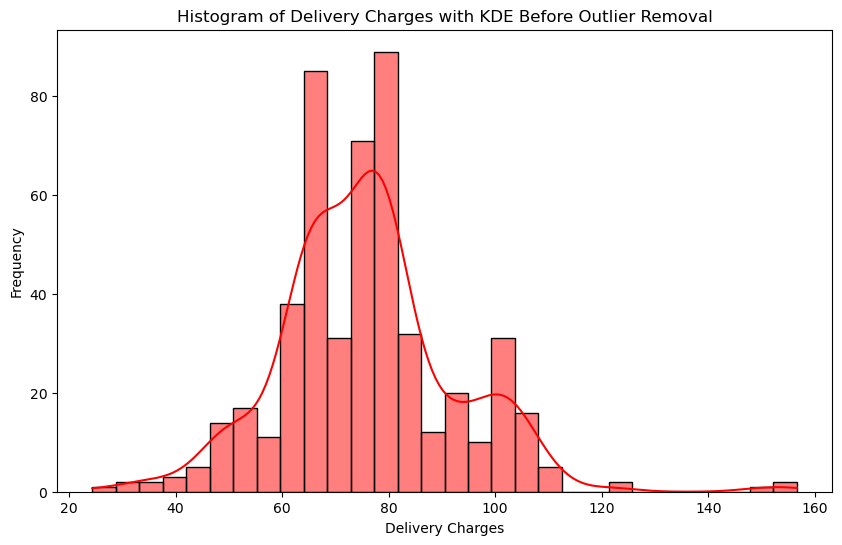

In [24]:
# Create a copy of the data before outlier removal
original_data_df = outlier_data_df.copy()

# Plot the histogram with KDE for delivery charges before outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(original_data_df['delivery_charges'], kde=True, bins=30, color='red')
plt.title('Histogram of Delivery Charges with KDE Before Outlier Removal')
plt.xlabel('Delivery Charges')
plt.ylabel('Frequency')
plt.show()


Number of Outliers detected: 19

Outliers detected using residuals approach (Before Removing):
      order_id  delivery_charges  predicted_delivery_charges  residuals
11   ORD359524           156.600                      103.46     53.140
46   ORD362113           121.620                       80.82     40.800
55   ORD336118            99.810                       66.93     32.880
93   ORD314088           121.605                       82.21     39.395
120  ORD307380            32.120                       64.91     32.790
125  ORD355490            37.785                       75.06     37.275
137  ORD180388           149.370                       97.93     51.440
157  ORD214619            99.360                       66.19     33.170
207  ORD416737           101.385                       68.27     33.115
221  ORD043907           104.910                       72.38     32.530
237  ORD291141            34.500                       68.04     33.540
267  ORD483506            39.905        

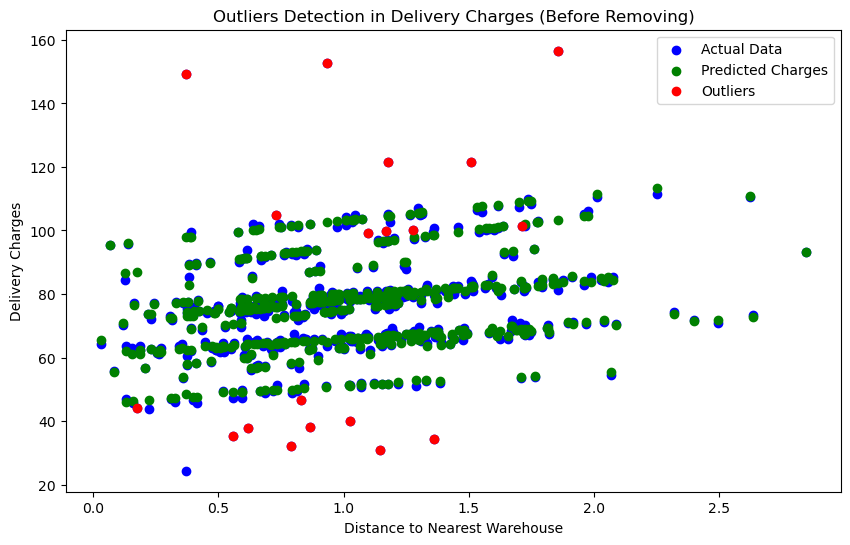


Number of Outliers detected (After Removing): 0

Remaining Outliers (If any):
Empty DataFrame
Columns: [order_id, delivery_charges, predicted_delivery_charges, residuals, order_total]
Index: []


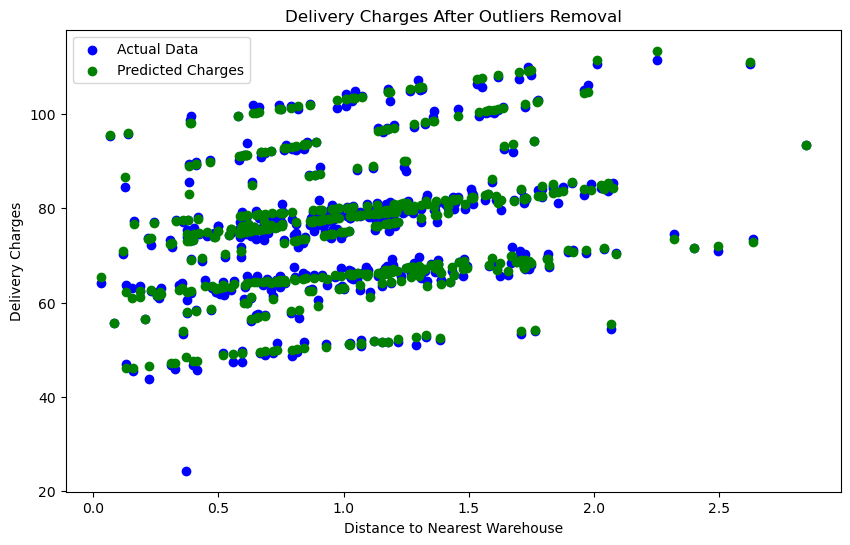

In [25]:
# Convert categorical features to numeric, if necessary (temporarily)
outlier_data_df['is_expedited_delivery_temp'] = outlier_data_df['is_expedited_delivery'].astype(int)
outlier_data_df['is_happy_customer_temp'] = outlier_data_df['is_happy_customer'].astype(int)

# Define the features to be used in prediction
features = ['distance_to_nearest_warehouse', 'is_expedited_delivery_temp', 'is_happy_customer_temp']

# Initialize a column for predicted charges
outlier_data_df['predicted_delivery_charges'] = np.nan

# Loop through each season and apply the corresponding model to predict delivery charges
for season, model in delivery_charge_models_by_season.items():
    # Filter data for the current season
    season_df = outlier_data_df[outlier_data_df['season'] == season]
    
    if not season_df.empty:
        # Predict delivery charges for the current season using the corresponding model
        X_test = season_df[features]
        predicted_charges = model.predict(X_test)
        predicted_charges = [round(charge, 2) for charge in predicted_charges]
        
        # Store the predicted charges in the outlier_data_df
        outlier_data_df.loc[season_df.index, 'predicted_delivery_charges'] = predicted_charges

# Calculate residuals (difference between actual and predicted values)
outlier_data_df['residuals'] = np.abs(outlier_data_df['delivery_charges'] - outlier_data_df['predicted_delivery_charges'])

# Set the threshold for outlier detection (mean residual + 3 * standard deviation)
threshold = outlier_data_df['residuals'].mean() + 3 * outlier_data_df['residuals'].std()

# Identify outliers (residuals greater than the threshold)
outliers = outlier_data_df[outlier_data_df['residuals'] > threshold]

# Output the number of outliers before removing
print(f"\nNumber of Outliers detected: {len(outliers)}")
print("\nOutliers detected using residuals approach (Before Removing):")
print(outliers[['order_id', 'delivery_charges', 'predicted_delivery_charges', 'residuals']])

# Plot the data before removing outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_data_df['distance_to_nearest_warehouse'], outlier_data_df['delivery_charges'], color='blue', label='Actual Data')
plt.scatter(outlier_data_df['distance_to_nearest_warehouse'], outlier_data_df['predicted_delivery_charges'], color='green', label='Predicted Charges')
plt.scatter(outliers['distance_to_nearest_warehouse'], outliers['delivery_charges'], color='red', label='Outliers')
plt.xlabel('Distance to Nearest Warehouse')
plt.ylabel('Delivery Charges')
plt.title('Outliers Detection in Delivery Charges (Before Removing)')
plt.legend()
plt.show()

# Remove outliers
outlier_data_df = outlier_data_df[outlier_data_df['residuals'] <= threshold]

# Print the number of outliers after removing
outliers_after_removal = outlier_data_df[outlier_data_df['residuals'] > threshold]
print(f"\nNumber of Outliers detected (After Removing): {len(outliers_after_removal)}")
print("\nRemaining Outliers (If any):")
print(outliers_after_removal[['order_id', 'delivery_charges', 'predicted_delivery_charges', 'residuals', 'order_total']])

# Plot the data after removing outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_data_df['distance_to_nearest_warehouse'], outlier_data_df['delivery_charges'], color='blue', label='Actual Data')
plt.scatter(outlier_data_df['distance_to_nearest_warehouse'], outlier_data_df['predicted_delivery_charges'], color='green', label='Predicted Charges')
plt.xlabel('Distance to Nearest Warehouse')
plt.ylabel('Delivery Charges')
plt.title('Delivery Charges After Outliers Removal')
plt.legend()
plt.show()

# Drop temporary columns used for analysis
outlier_data_df = outlier_data_df.drop(columns=['predicted_delivery_charges', 'residuals', 'is_expedited_delivery_temp', 'is_happy_customer_temp'])



##### This code is designed to detect, remove, and visualize outliers in delivery charges, specifically focusing on how these charges are influenced by the distance between the customer's location and the nearest warehouse. The process uses season-specific linear regression models to predict delivery charges and handles discrepancies (outliers) between predicted and actual delivery charges.

1. Data Preprocessing: To ensure that the model can process categorical variables (like is_expedited_delivery and is_happy_customer), these columns are temporarily converted into integer values (1 for True, 0 for False). The temporary columns, is_expedited_delivery_temp and is_happy_customer_temp, are used solely for the purpose of making predictions in a numeric format that the linear regression models can understand.
Additionally, a column predicted_delivery_charges is initialized to store the predicted delivery charges for each row. These predictions will be based on season-specific models trained for different periods, such as Winter, Summer, etc.

2. Prediction of Delivery Charges: For each season (e.g., Winter, Summer), the corresponding pre-trained linear regression model is applied to predict delivery charges. The features used for this prediction include: distance_to_nearest_warehouse, is_expedited_delivery_temp (whether expedited delivery is chosen), is_happy_customer_temp (customer satisfaction level). The predicted delivery charges are rounded to two decimal places and stored in the predicted_delivery_charges column. This ensures that the predicted values are precise and ready for further analysis.

3. Outlier Detection Using Residuals: To detect outliers, residuals are calculated by finding the absolute difference between the actual delivery charges and the predicted delivery charges. Outliers are identified as rows where the residuals exceed a defined threshold. This threshold is set as the mean residual plus three times the standard deviation, which ensures that unusually high deviations from expected delivery charges are captured.
The code visualizes the data before outlier removal. Outliers are highlighted in red, predicted charges in green, and actual data in blue, providing a visual representation of deviations from the model predictions.

4. Outlier Removal: For rows identified as outliers, where the residuals exceed the threshold, the rows are removed entirely from the dataset. This step ensures that only valid and expected delivery charge data remains in the final dataset, free from extreme deviations that could skew analysis.
After removing the outliers, residuals are recalculated to confirm that no further outliers remain.

5. Revisualization After Outlier Removal: After removing outliers, the data is visualized again. This step shows the updated dataset, ensuring that outliers have been effectively removed. The scatter plot visualizes the relationship between distance_to_nearest_warehouse and the actual delivery charges, confirming that the removal of outliers has resulted in a cleaner dataset.

6. Temporary Columns Usage: To facilitate the prediction models, categorical features like is_expedited_delivery and is_happy_customer are temporarily converted into integer representations using the columns is_expedited_delivery_temp and is_happy_customer_temp. This conversion enables the linear regression models to work with numeric data.
After the predictions and outlier removal are complete, these temporary columns are dropped, and the data is reverted to its original state, where is_expedited_delivery and is_happy_customer are represented as True/False values. This ensures consistency in the dataset for further analysis or output after the correction process.

7. Outlier Removal Process: Once outliers have been detected, they are removed from the dataset. The remaining data, without the outliers, is then used for further analysis. A count of the rows affected by the removal process is recorded both before and after the operation. This ensures that the final dataset is free from outliers and ready for downstream tasks.

##### Histogram with KDE (Kernel Density Estimation)

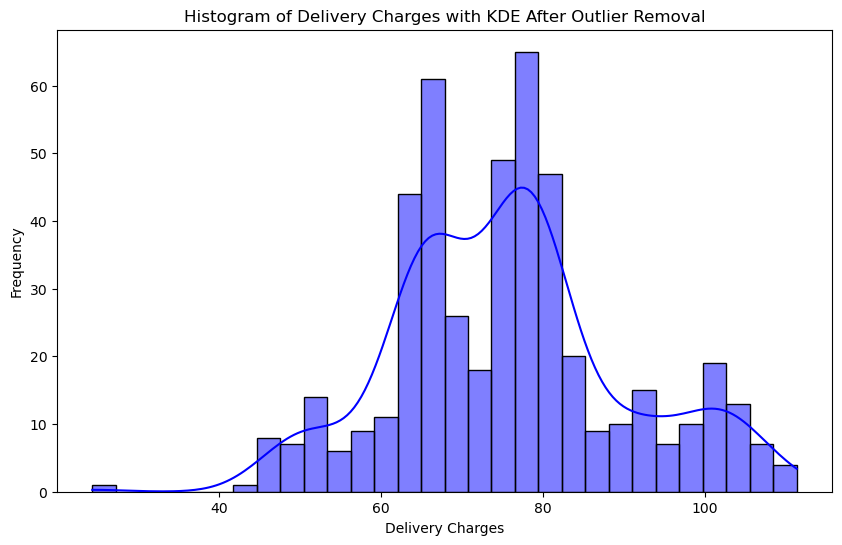

In [26]:
# Create a Histogram with KDE for delivery charges after outlier removal
plt.figure(figsize=(10, 6))
sns.histplot(outlier_data_df['delivery_charges'], kde=True, bins=30, color='blue')
plt.title('Histogram of Delivery Charges with KDE After Outlier Removal')
plt.xlabel('Delivery Charges')
plt.ylabel('Frequency')
plt.show()

1. Distribution Characteristics: The histogram exhibits a multi-modal distribution, with prominent peaks around delivery charges of 60, 70, and 80 units. This indicates that delivery charges tend to cluster around these values, suggesting that the majority of charges fall within these distinct ranges.
The KDE curve (represented by the blue line) effectively smooths the histogram, offering a continuous view of the probability density. The curve confirms that the majority of delivery charges lie between approximately 40 and 100 units.

2. Impact of Outlier Removal: The absence of extreme values in the histogram, particularly in the far-left or far-right regions, signifies the successful removal of outliers from the dataset. This has resulted in a cleaner, more representative distribution of delivery charges, free from distortion caused by abnormally high or low charges.
The distribution now reflects a more natural range of values, as the extreme fluctuations that could skew analytical outcomes have been addressed.

3. Concentration of Charges: The majority of delivery charges are concentrated between 40 and 100 units, with the KDE curve highlighting this as the area of highest density. This suggests that, post-outlier removal, the charges are more consistently distributed and follow a reasonable pattern.
The distribution's peaks around specific values indicate that delivery charges tend to standardize within these ranges, which may reflect operational pricing strategies or logistical factors that influence typical delivery costs.

#### Saving the imputed outlier data to 'Group110_outlier_data_solution.csv'

In [27]:
# Save the updated data with imputed outliers to CSV
outlier_data_df.to_csv('Group110_outlier_data_solution.csv', index=False)

print(outlier_data_df.head(30))

print("The updated data has been saved to Group110_outlier_data_solution.csv.")

     order_id   customer_id        date nearest_warehouse  \
0   ORD052408  ID6167289319  2019-09-17         Nickolson   
1   ORD223989  ID0440506809  2019-11-13            Bakers   
2   ORD403939  ID1449431615  2019-09-12         Nickolson   
3   ORD261684  ID2941596454  2019-03-20         Nickolson   
4   ORD027174  ID2672310960  2019-11-26            Bakers   
5   ORD244718  ID3790949323  2019-10-16          Thompson   
6   ORD180014  ID4326586188  2019-10-15         Nickolson   
7   ORD054149  ID1282403447  2019-05-15          Thompson   
8   ORD018637  ID0441031454  2019-01-17          Thompson   
9   ORD161722  ID0598347148  2019-03-01         Nickolson   
10  ORD090617  ID0305106878  2019-09-26          Thompson   
12  ORD293478  ID0282825793  2019-10-09          Thompson   
13  ORD435465  ID0777697587  2019-09-10          Thompson   
14  ORD185137  ID0664377811  2019-04-03         Nickolson   
15  ORD219798  ID3213448179  2019-02-25          Thompson   
16  ORD234570  ID0202774

<div class="alert alert-block alert-success"> 

#### REFERENCES

1. GeeksforGeeks. (n.d.). Python itertools.permutations. GeeksforGeeks. https://www.geeksforgeeks.org/python-itertools-permutations/

2. Stack Overflow. (2011, February 7). Haversine formula in Python (bearing and distance between two GPS points). Stack Overflow. https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

3. NLTK. (n.d.). nltk.sentiment.vader module. Natural Language Toolkit. https://www.nltk.org/api/nltk.sentiment.vader.html

4. NumPy. (n.d.). numpy.linalg.solve — NumPy v1.24 manual. NumPy. https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve

5. Scikit-learn. (n.d.). sklearn.linear_model.LinearRegression. Scikit-learn 1.5. https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html

6. Stack Exchange. (n.d.). Encoding for linear regression. Data Science Stack Exchange. https://datascience.stackexchange.com/questions/115172/encoding-for-linear-regression

<div class="alert alert-block alert-success"> 

### ACKNOWLEDGEMENT

* We acknowledge the assistance of ChatGPT, powered by OpenAI, in completing certain parts of this assignment. The use of this AI tool provided valuable support in areas such as   shopping_cart error fixes, latitude longitude error correction, model training for imputing delivery_charges in missing_data and enhancing the overall quality of the work. 
OpenAI. (2023). ChatGPT (GPT-4). https://openai.com/chatgpt